Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github

# CoronaVirus Prediction

### Number of Day to Predict 42

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=42
num_BackTrack_Days=4

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=24 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
#
drop_n_dataset_days=520
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
254                                           NaN                 Tunisia   
255                                           NaN                  Turkey   
256                                           NaN           United States   
257                                           NaN                  Uganda   
258                                           NaN                 Ukraine   
259                                           NaN    United Arab Emirates   
260                                      Anguilla          United Kingdom   
261                                       Bermuda          United Kingdom   
262                        British Virgin Islands          United Kingdom   
263                                Cayman Islands          United Kingdom   
264                               Channel Islands          United Kingdom   
265                   Falkland Islands (Malvinas)          United Kingdom   
266                                     Gibraltar          United Kingdom   
267                                      Guernsey          United Kingdom   
268                                   Isle of Man          United Kingdom   
269                                        Jersey          United Kingdom   
270                                    Montserrat          United Kingdom   
271  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
272                      Turks and Caicos Islands          United Kingdom   
273                                           NaN          United Kingdom   
274                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
260                                           NaN                 Tunisia   
261                                           NaN                  Turkey   
262                                           NaN           United States   
263                                           NaN                  Uganda   
264                                           NaN                 Ukraine   
265                                           NaN    United Arab Emirates   
266                                      Anguilla          United Kingdom   
267                                       Bermuda          United Kingdom   
268                        British Virgin Islands          United Kingdom   
269                                Cayman Islands          United Kingdom   
270                               Channel Islands          United Kingdom   
271                   Falkland Islands (Malvinas)          United Kingdom   
272                                     Gibraltar          United Kingdom   
273                                      Guernsey          United Kingdom   
274                                   Isle of Man          United Kingdom   
275                                        Jersey          United Kingdom   
276                                    Montserrat          United Kingdom   
277  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
278                      Turks and Caicos Islands          United Kingdom   
279                                           NaN          United Kingdom   
280                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  2/8/22  2/9/22  2/10/22  \
185        0        0        0        0  ...     715     715      715   
186        0        0        0        0  ...     570     572      576   
187        0        0        0        0  ...       0       0        0   
188        0        0        0        0  ...     969     971      971   
189        0        0        0        0  ...     786     786      786   
190        0        0        0        0  ...  309884  310627   310627   
191        0        0        0        0  ...       0       0        0   
192        0        0        0        0  ...   10803   10837    10866   
193        0        0        0        0  ...      48      49       49   
194        0        0        0        0  ...    2134    2137     2139   

     2/11/22  2/12/22  2/13/22  2/14/22  2/15/22   Population   \
185      716      716      716      716      717    20,250,833   
186      579      585      589      592      593       441,543   
187        0        0        0        0        0           NaN   
188      971      972      972      973      973     4,649,658   
189      786      786      786      786      786     1,273,985   
190   311554   312697   312697   312819   312965   128,640,794   
191        0        0        0        0        0           NaN   
192    10893    10924    10940    10962    10982     4,035,942   
193       49       49       49       50       50        39,183   
194     2144     2145     2146     2148     2149     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 762 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN        Moldova  47.411600   28.36990   
176                               NaN         Monaco  43.733300    7.41670   
177                               NaN       Mongolia  46.862500  103.84670   
178                               NaN     Montenegro  42.708678   19.37439   
179                               NaN        Morocco  31.791700   -7.09260   
180                               NaN     Mozambique -18.665700   35.52960   
181                               NaN        Namibia -22.957600   18.49040   
182                               NaN          Nepal  28.166700   84.25000   
183                             Aruba    Netherlands  12.521100  -69.96830   
184  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  2/8/22  \
175        0        0        0        0        0        0  ...       0   
176        0        0        0        0        0        0  ...       0   
177        0        0        0        0        0        0  ...       0   
178        0        0        0        0        0        0  ...       0   
179        0        0        0        0        0        0  ...       0   
180        0        0        0        0        0        0  ...       0   
181        0        0        0        0        0        0  ...       0   
182        0        0        0        0        0        0  ...       0   
183        0        0        0        0        0        0  ...       0   
184        0        0        0        0        0        0  ...       0   

     2/9/22  2/10/22  2/11/22  2/12/22  2/13/22  2/14/22  2/15/22  \
175       0        0        0        0        0        0        0   
176       0        0        0        0        0        0        0   
177       0        0        0        0        0        0        0   
178       0        0        0        0        0        0        0   
179       0        0        0        0        0        0        0   
180       0        0        0        0        0        0        0   
181       0        0        0        0        0        0        0   
182       0        0        0        0        0        0        0   
183       0        0        0        0        0        0        0   
184       0        0        0        0        0        0        0   

      Population                                         region  
175     4,035,942                                   Moldova_nan  
176        39,183                                    Monaco_nan  
177     3,278,290                                  Mongolia_nan  
178       622 500                                Montenegro_nan  
179    36,817,128                                   Morocco_nan  
180    31,542,919                                Mozambique_nan  
181     2,540,905                                   Namibia_nan  
182    29,300,000                                     Nepal_nan  
183       116,600                             Netherlands_Aruba  
184        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 762 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...   2/8/22   2/9/22  2/10/22  \
185        0        0        0        0  ...    30227    30236    30251   
186        0        0        0        0  ...    69361    69533    69651   
187        0        0        0        0  ...        7        7        7   
188        0        0        0        0  ...    58508    58527    58542   
189        0        0        0        0  ...    70862    70862    70862   
190        0        0        0        0  ...  5167110  5192008  5192008   
191        0        0        0        0  ...        1        1        1   
192        0        0        0        0  ...   471524   474548   477419   
193        0        0        0        0  ...     8880     8922     8956   
194        0        0        0        0  ...   860976   863372   864564   

     2/11/22  2/12/22  2/13/22  2/14/22  2/15/22   Population   \
185    30257    30259    30265    30266    30286    20,250,833   
186    69794    69901    70017    70089    70211       441,543   
187        7        7        7        7        7           NaN   
188    58557    58563    58569    58575    58577     4,649,658   
189    70862    70862    70862    70862    70862     1,273,985   
190  5226269  5283852  5283852  5292706  5300537   128,640,794   
191        1        1        1        1        1           NaN   
192   480289   482842   484516   485563   487283     4,035,942   
193     8988     9020     9020     9020     9085        39,183   
194   875440   875440   875440   885554   888363     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 762 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                            Poland  51.919400   19.145100   
221            NaN                          Portugal  39.399900   -8.224500   
222            NaN                             Qatar  25.354800   51.183900   
223            NaN                           Romania  45.943200   24.966800   
224            NaN                            Russia  61.524010  105.318756   
225            NaN                            Rwanda  -1.940300   29.873900   
226            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
227            NaN                       Saint Lucia  13.909400  -60.978900   
228            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
229            NaN                             Samoa -13.759000 -172.104600   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...    2/8/22  \
220        0        0        0        0        0        0  ...   5217106   
221        0        0        0        0        0        0  ...   2963747   
222        0        0        0        0        0        0  ...    347365   
223        0        0        0        0        0        0  ...   2455048   
224        0        0        0        0        0        0  ...  12946888   
225        0        0        0        0        0        0  ...    129177   
226        0        0        0        0        0        0  ...      5488   
227        0        0        0        0        0        0  ...     21768   
228        0        0        0        0        0        0  ...      8134   
229        0        0        0        0        0        0  ...        33   

       2/9/22   2/10/22   2/11/22   2/12/22   2/13/22   2/14/22   2/15/22  \
220   5258785   5296386   5328492   5356647   5376674   5388907   5408754   
221   2997770   3025421   3049692   3069128   3085260   3093723   3111858   
222    348141    348924    349581    350188    350801    351402    351949   
223   2482394   2508860   2531597   2550348   2562315   2574384   2596269   
224  13128679  13323972  13526183  13728138  13923951  14102736  14267875   
225    129210    129234    129278    129295    129298    129311    129326   
226      5492      5495      5497      5498      5499      5505      5508   
227     21831     21873     21932     21932     22048     22121     22177   
228      8144      8144      8144      8144      8144      8246      8248   
229        33        33        33        33        33        33        33   

      Population                                 region  
220    37,980,000                            Poland_nan  
221    10,290,000                          Portugal_nan  
222     2,870,256                             Qatar_nan  
223    19,530,000                           Romania_nan  
224   144,500,000                            Russia_nan  
225    12,952,218                            Rwanda_nan  
226        53,673             Saint Kitts and Nevis_nan  
227       184,106                       Saint Lucia_nan  
228       110,940  Saint Vincent and the Grenadines_nan  
229           NaN                             Samoa_nan  

[10 rows x 762 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

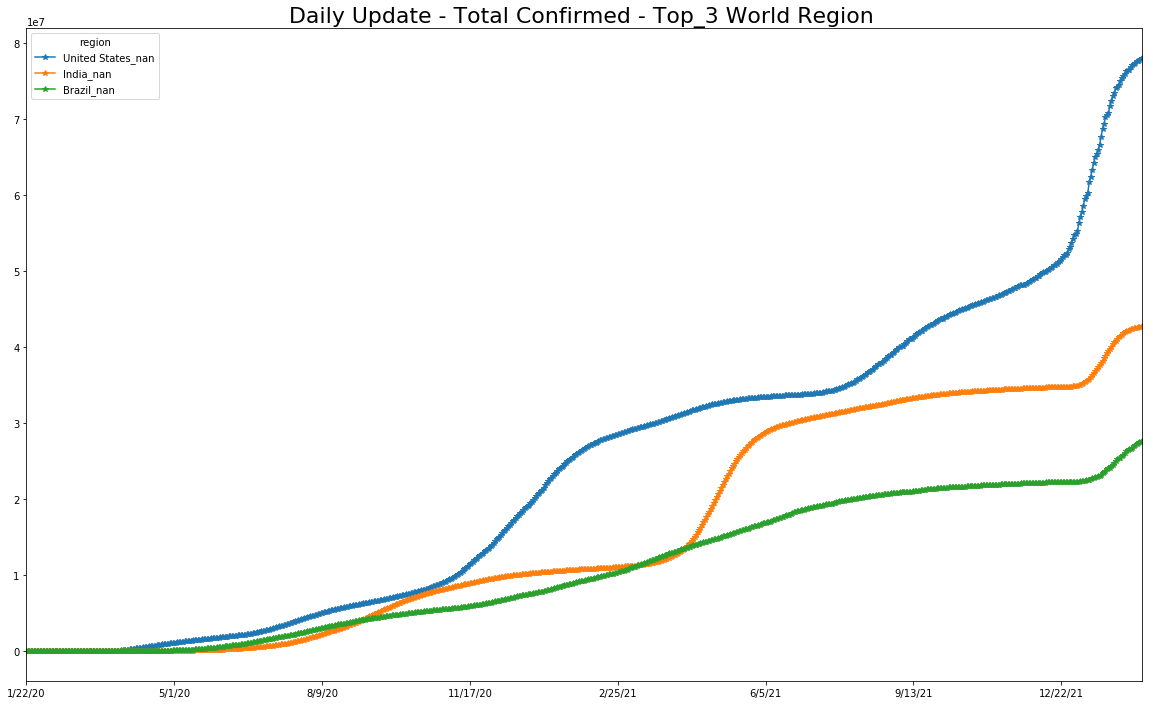

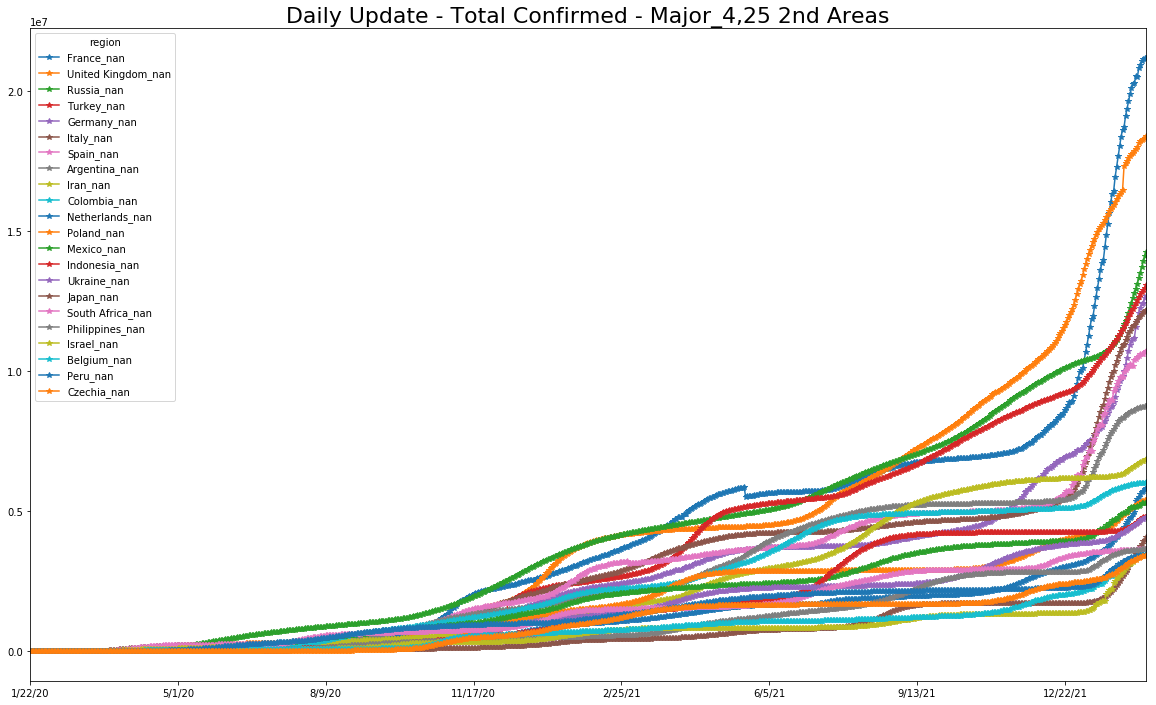

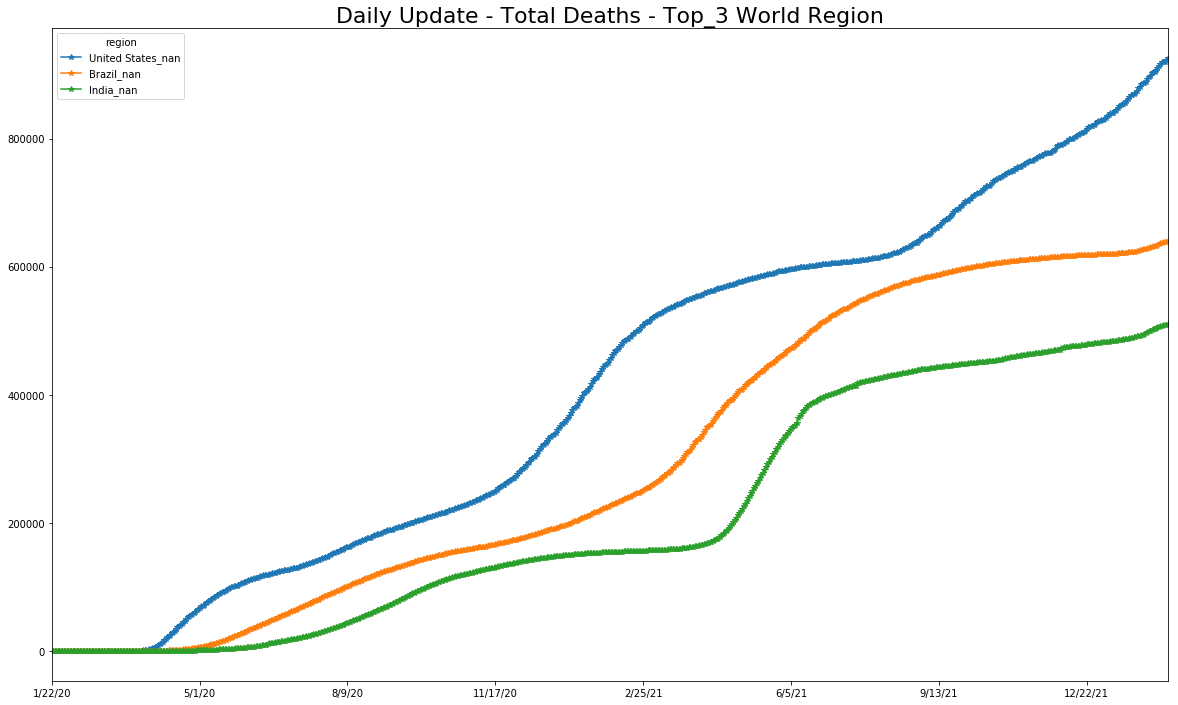

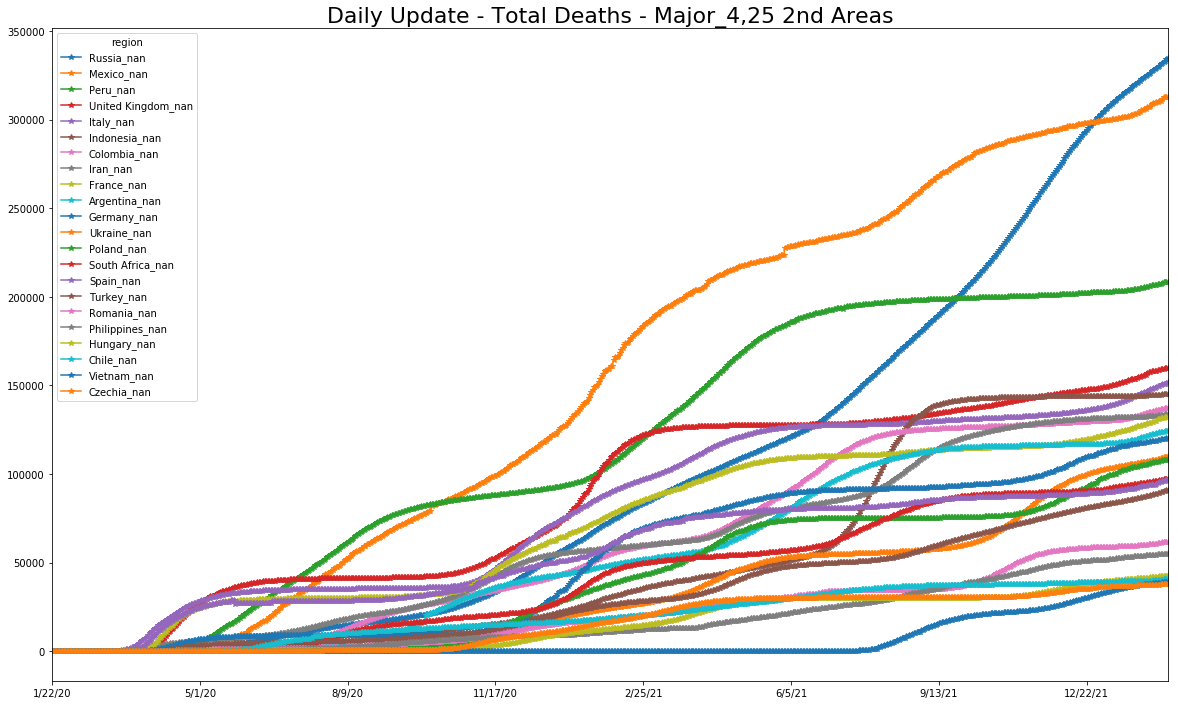

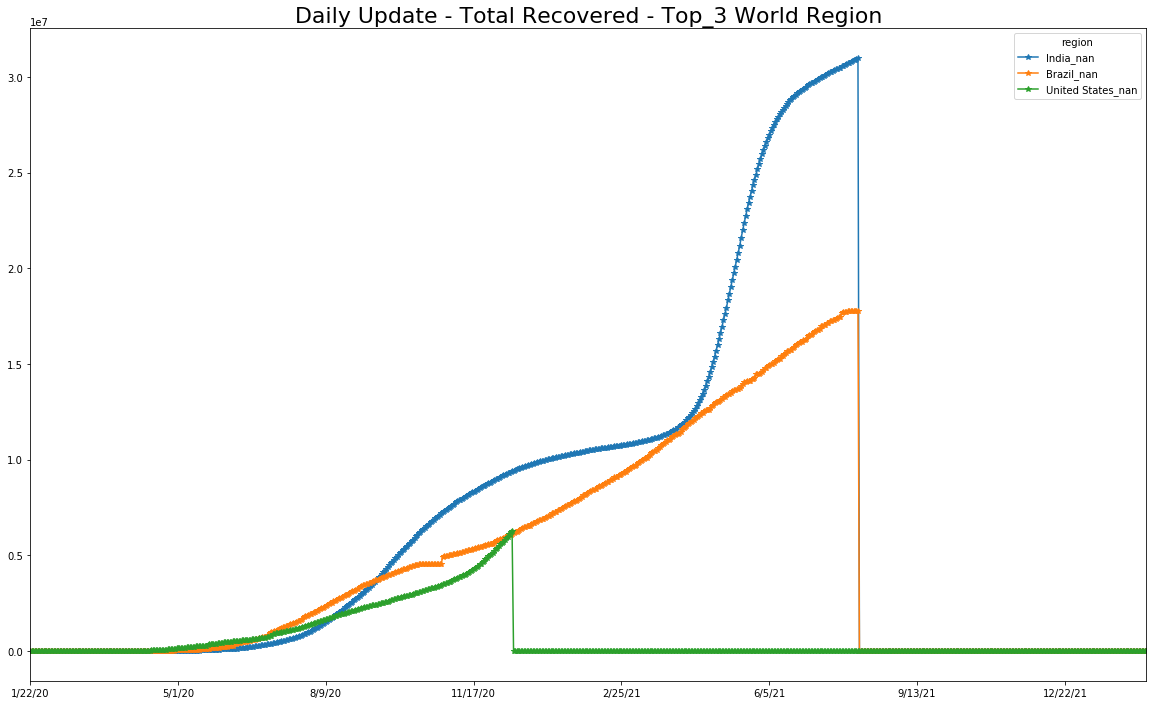

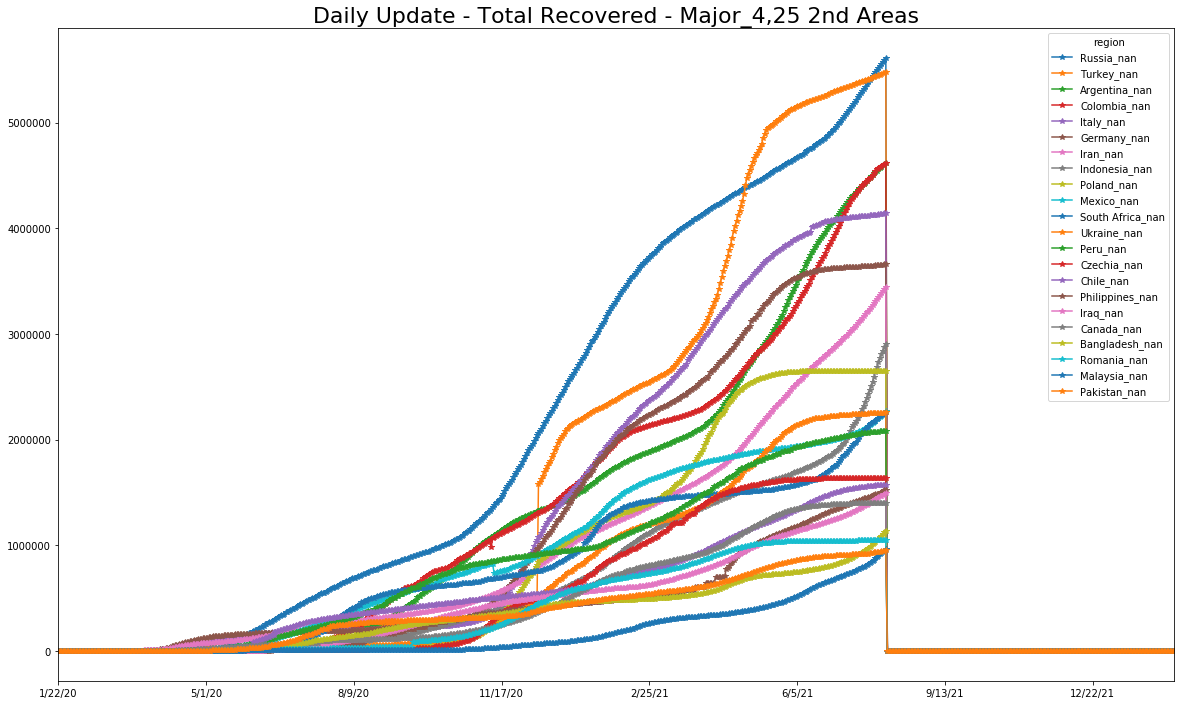

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/02/16


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
6/25/21           111592       132506       137772        13882       38371   
6/26/21           113124       132509       138113        13882       38528   
6/27/21           114220       132512       138465        13882       38556   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
6/25/21               0                     1263        4374587       224635   
6/26/21               0                     1263        4393142       224728   
6/27/21               0                     1263        4405247       224797   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
6/25/21                                     124  ...       363580   
6/26/21                                     124  ...       364859   
6/27/21                                     124  ...       365866   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
6/25/21          108184            4         266952        14537   
6/26/21          108730            4         268349        15325   
6/27/21          109223            4         269635        15740   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
6/25/21                  313520                         0       6905   
6/26/21                  313520                         0       6906   
6/27/21                  313721                         0       6908   

region   Zambia_nan  Zimbabwe_nan  
6/25/21      143215         45217  
6/26/21      146031         46018  
6/27/21      148568         46442  

[3 rows x 284 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
2/12/22           170152       267551       261226        37140       98514   
2/13/22           170604       268008       261752        37140       98514   
2/14/22           171246       268304       262165        37277       98514   
2/15/22           171422       268491       262570        37361       98555   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
2/12/22              11                     7331        8728262       404805   
2/13/22              11                     7331        8734551       406379   
2/14/22              11                     7331        8747601       407074   
2/15/22              11                     7342        8766174       408381   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
2/12/22                                   41380  ...       772757   
2/13/22                                   41755  ...       777490   
2/14/22                                   42163  ...       782556   
2/15/22                                   42720  ...       788676   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
2/12/22          233000            7         503162      2484481   
2/13/22          233439            7         504719      2510860   
2/14/22          233761            7         505947      2540273   
2/15/22          234063            7         506977      2572087   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
2/12/22                  600128                       498      11664   
2/13/22                  600128                       501      11671   
2/14/22                  613846                       501      11679   
2/15/22                  618527                       505      11699   

region   Zambia_nan  Zimbabwe_nan  
2/12/22      309293        231299  
2/13/22      309502        231381  
2/14/22      309579        231603  
2/15/22      309870        231603  

[4 rows x 284 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-06-26  Afghanistan_nan     113124             0             0   
2     2021-06-27  Afghanistan_nan     114220          1532             0   
3     2021-06-28  Afghanistan_nan     115751          1096             0   
4     2021-06-29  Afghanistan_nan     117158          1531          4159   
5     2021-06-30  Afghanistan_nan     118659          1407          4034   
6     2021-07-01  Afghanistan_nan     120216          1501          4439   
7     2021-07-02  Afghanistan_nan     122156          1557          4465   
8     2021-07-03  Afghanistan_nan     123485          1940          4998   
9     2021-07-04  Afghanistan_nan     124748          1329          4826   
10    2021-07-05  Afghanistan_nan     125937          1263          4532   
11    2021-07-06  Afghanistan_nan     127464          1189          3781   
12    2021-07-07  Afghanistan_nan     129021          1527          3979   
13    2021-07-08  Afghanistan_nan     130113          1557          4273   
14    2021-07-09  Afghanistan_nan     131586          1092          4176   
15    2021-07-10  Afghanistan_nan     132777          1473          4122   
16    2021-07-11  Afghanistan_nan     133578          1191          3756   
17    2021-07-12  Afghanistan_nan     134653           801          3465   
18    2021-07-13  Afghanistan_nan     135889          1075          3067   
19    2021-07-14  Afghanistan_nan     136643          1236          3112   
20    2021-07-15  Afghanistan_nan     137853           754          3065   
21    2021-07-16  Afghanistan_nan     139051          1210          3200   
22    2021-07-17  Afghanistan_nan     140224          1198          3162   
23    2021-07-18  Afghanistan_nan     140602          1173          3581   
24    2021-07-19  Afghanistan_nan     141499           378          2749   
25    2021-07-20  Afghanistan_nan     142414           897          2448   
26    2021-07-21  Afghanistan_nan     142762           915          2190   
27    2021-07-22  Afghanistan_nan     143183           348          2160   
28    2021-07-23  Afghanistan_nan     143439           421          1684   
29    2021-07-24  Afghanistan_nan     143666           256          1025   
30    2021-07-25  Afghanistan_nan     143871           227           904   
...          ...              ...        ...           ...           ...   
68700 2022-01-18     Zimbabwe_nan     226460           382           823   
68701 2022-01-19     Zimbabwe_nan     226887             0           823   
68702 2022-01-20     Zimbabwe_nan     227552           427           809   
68703 2022-01-21     Zimbabwe_nan     227961           665          1092   
68704 2022-01-22     Zimbabwe_nan     228179           409          1501   
68705 2022-01-23     Zimbabwe_nan     228254           218          1292   
68706 2022-01-24     Zimbabwe_nan     228541            75           702   
68707 2022-01-25     Zimbabwe_nan     228776           287           580   
68708 2022-01-26     Zimbabwe_nan     228943           235           597   
68709 2022-01-27     Zimbabwe_nan     229096           167           689   
68710 2022-01-28     Zimbabwe_nan     229333           153           555   
68711 2022-01-29     Zimbabwe_nan     229415           237           557   
68712 2022-01-30     Zimbabwe_nan     229460            82           472   
68713 2022-01-31     Zimbabwe_nan     229666            45           364   
68714 2022-02-01     Zimbabwe_nan     229851           206           333   
68715 2022-02-02     Zimbabwe_nan     230012           185           436   
68716 2022-02-03     Zimbabwe_nan     230170           161           552   
68717 2022-02-04     Zimbabwe_nan     230170           158           504   
68718 2022-02-05     Zimbabwe_nan     230402             0           319   
68719 2022-02-06     Zimbabwe_nan     230402           232           390   
68720 2022-02-07     Zimbabwe_nan     230402             0  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
68729 2022-02-16  Zimbabwe_nan          0             0           304   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
68729          1000         100.000004         100.131436          100.43365   

       last_day  kalman_prediction  population  infected_rate  min  max  
68729    231603           231809.0    14862924       0.000156  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
68729 2022-02-16  Zimbabwe_nan          0             0           304   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
68729          1000         100.000004         100.131436          100.43365   

       last_day  kalman_prediction  population  infected_rate  min  max  
68729    231603           231809.0    14862924       0.000156  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
67305  2022-02-14  Zimbabwe_nan     231603            82           341   
67306  2022-02-15  Zimbabwe_nan     231603           222           389   
67307  2022-02-16  Zimbabwe_nan          0             0           304   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
67305           979         100.035456         100.147598         100.424914   
67306          1201         100.095950         100.168247         100.521267   
67307          1000         100.000004         100.131436         100.433650   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
67305               231381  ...    14862924       0.000156  NaN  NaN   
67306               231603  ...    14862924       0.000156  NaN  NaN   
67307               231603  ...    14862924       0.000156  NaN  NaN   

       population_percentage : infected_rate confirmed  \
67305                                         0.015568   
67306                                         0.015583   
67307                                         0.015583   

       population_percentage : factor 9/10 infected_rate confirmed  \
67305                                           0.140110             
67306                                           0.140244             
67307                                           0.140244             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
67305                   187.0                          12.581643   
67306                   136.0                           9.150286   
67307                   206.0                          13.859991   

       delta : roling 7day AVG  \
67305               139.857143   
67306               171.571429   
67307               142.857143   

       delta : aprox 14-day case notification rate per 100k hab  
67305                                          13.173720         
67306                                          16.161019         
67307                                          13.456302         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
273  United States_nan  2.605893e+13  5.104795e+06  452927.279661


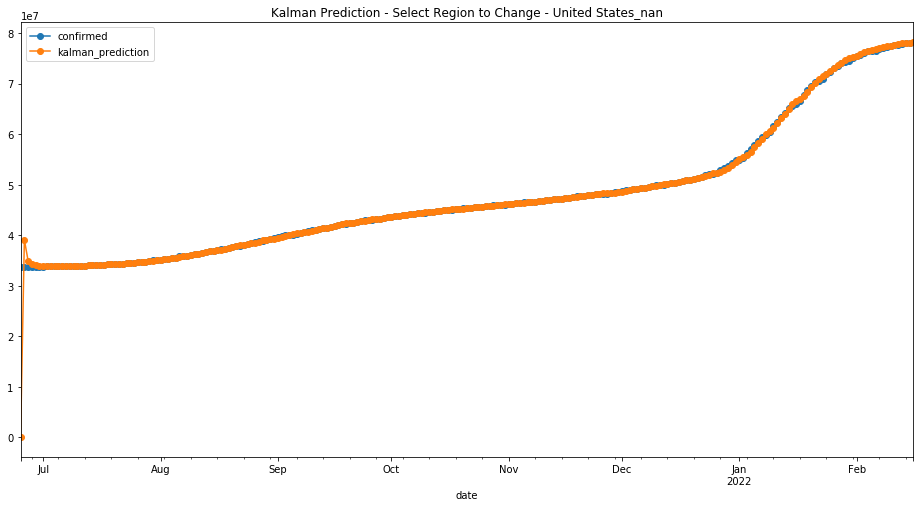

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
218  Russia_nan  8.909656e+11  943909.755962  73318.822034


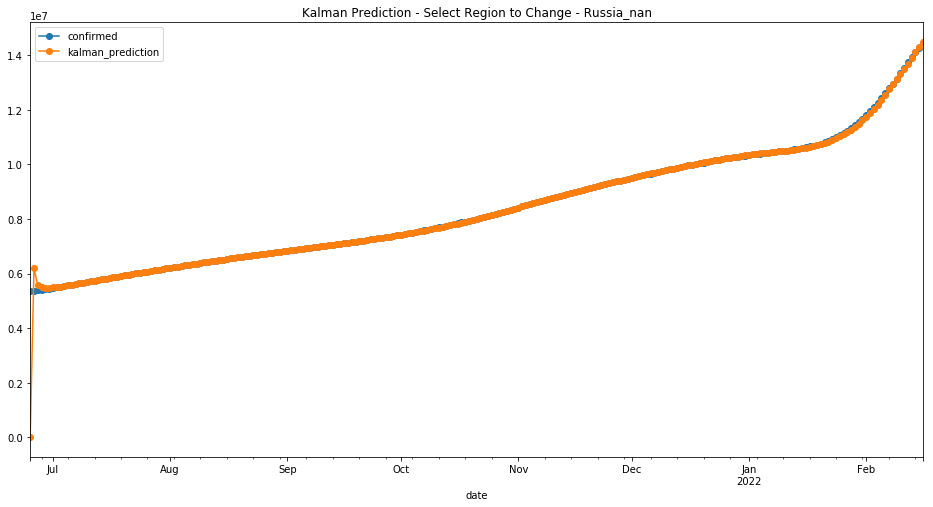

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  3.317215e+12  1.821322e+06  155722.279661


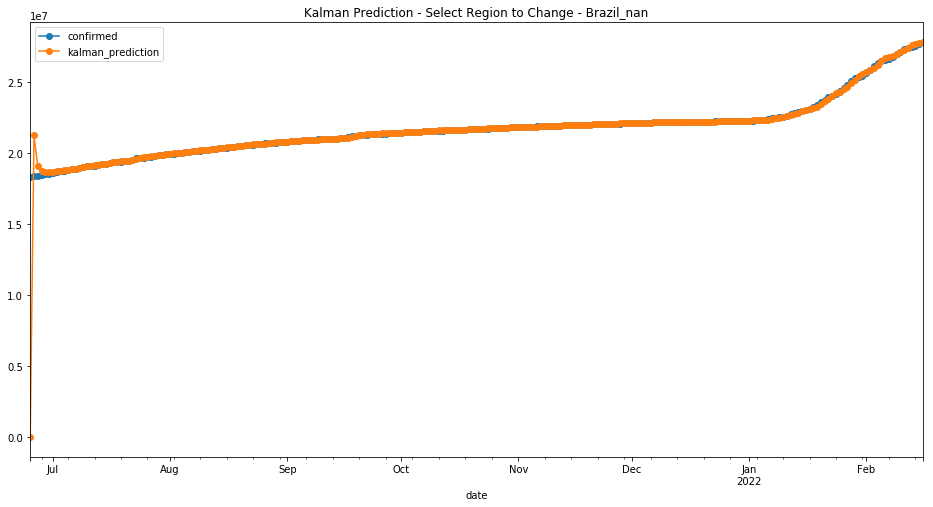

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
272  United Kingdom_nan  1.451803e+12  1.204908e+06  105041.444915


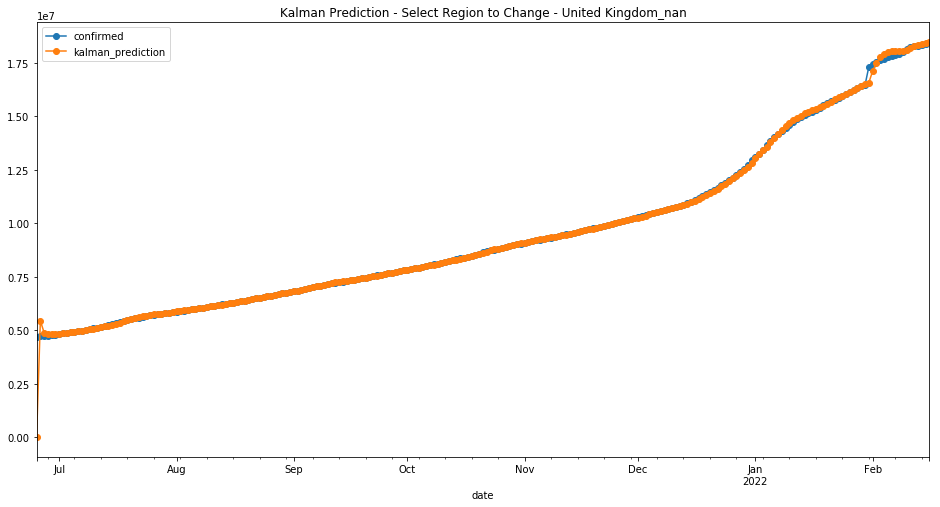

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5lqbhefz
  JVM stdout: /tmp/tmp5lqbhefz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5lqbhefz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 3 months and 20 days !!!
H2O cluster name:           H2O_from_python_unknownUser_4zktn3
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-01-23
last_train_date= 2022-02-15
first_bootstrap_date= 2022-02-07
boost_bootstrap_date= 2022-02-12
first_test_date= 2022-02-06
last_test_date= 2022-02-16
first_valid_date= 2022-02-14


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   168483.0     166924 2022-02-07  Afghanistan_nan
1   169144.0     167739 2022-02-08  Afghanistan_nan
2   169904.0     168550 2022-02-09  Afghanistan_nan
3   170722.0     169448 2022-02-10  Afghanistan_nan
4   171636.0     169940 2022-02-11  Afghanistan_nan
5   172250.0     170152 2022-02-12  Afghanistan_nan
6   172570.0     170604 2022-02-13  Afghanistan_nan
7   172979.0     171246 2022-02-14  Afghanistan_nan
8   173512.0     171422 2022-02-15  Afghanistan_nan
9   173712.0          0 2022-02-16  Afghanistan_nan
10  266389.0     264875 2022-02-07      Albania_nan
11  266528.0     265716 2022-02-08      Albania_nan
12  267275.0     266416 2022-02-09      Albania_nan
13  267905.0     267020 2022-02-10      Albania_nan
14  268353.0     267020 2022-02-11      Albania_nan
15  268361.0     267551 2022-02-12      Albania_nan
16  268791.0     268008 2022-02-13      Albania_nan
17  269143.0     268304 2022-02-14      Albania_nan
18  269340.0     268491 2022-02-15      Albania_nan
19  269504.0          0 2022-02-16      Albania_nan
20  260792.0     258478 2022-02-07      Algeria_nan
21  261175.0     259088 2022-02-08      Algeria_nan
22  261621.0     259673 2022-02-09      Algeria_nan
23  262072.0     260191 2022-02-10      Algeria_nan
24  262492.0     260723 2022-02-11      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  2246793.0    2248713 2022-02-12     Austria_nan
176  2278306.0    2274664 2022-02-13     Austria_nan
177  2303417.0    2299229 2022-02-14     Austria_nan
178  2327716.0    2324406 2022-02-15     Austria_nan
179  2351994.0          0 2022-02-16     Austria_nan
180   704903.0     703334 2022-02-07  Azerbaijan_nan
181   709500.0     710366 2022-02-08  Azerbaijan_nan
182   717515.0     718145 2022-02-09  Azerbaijan_nan
183   725342.0     725777 2022-02-10  Azerbaijan_nan
184   732903.0     732380 2022-02-11  Azerbaijan_nan
185   739504.0     738328 2022-02-12  Azerbaijan_nan
186   745641.0     745169 2022-02-13  Azerbaijan_nan
187   752750.0     747918 2022-02-14  Azerbaijan_nan
188   754478.0     752605 2022-02-15  Azerbaijan_nan
189   759629.0          0 2022-02-16  Azerbaijan_nan
190    33569.0      32802 2022-02-07     Bahamas_nan
191    33658.0      32833 2022-02-08     Bahamas_nan
192    33687.0      32833 2022-02-09     Bahamas_nan
193    33750.0      32871 2022-02-10     Bahamas_nan
194    33706.0      32903 2022-02-11     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   48134.0      48658 2022-02-07  Barbados_nan
221   48588.0      49372 2022-02-08  Barbados_nan
222   48852.0      49958 2022-02-09  Barbados_nan
223   49555.0      50477 2022-02-10  Barbados_nan
224   50154.0      50880 2022-02-11  Barbados_nan
225   50684.0      51311 2022-02-12  Barbados_nan
226   51052.0      51624 2022-02-13  Barbados_nan
227   51463.0      51895 2022-02-14  Barbados_nan
228   51736.0      52310 2022-02-15  Barbados_nan
229   51910.0          0 2022-02-16  Barbados_nan
230  782008.0     783260 2022-02-07   Belarus_nan
231  788375.0     788934 2022-02-08   Belarus_nan
232  795013.0     797188 2022-02-09   Belarus_nan
233  804191.0     805651 2022-02-10   Belarus_nan
234  812666.0     814262 2022-02-11   Belarus_nan
235  821606.0     823045 2022-02-12   Belarus_nan
236  830822.0     831966 2022-02-13   Belarus_nan
237  840165.0     838571 2022-02-14   Belarus_nan
238  846540.0     843717 2022-02-15   Belarus_nan
239  851678.0          0 2022-02-16   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  129928900473.75221
# MSE on the validation data =  84598527840253.72
# R^2 on the training data =  0.9987737223034636
# R^2 on the validation data =  0.46284023282473086


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1644997924163_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 129928900473.75221
RMSE: 360456.51675861294
MAE: 25008.090006414583
RMSLE: 0.44364553339527146
Mean Residual Deviance: 129928900473.75221

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 84598527840253.72
RMSE: 9197745.802111173
MAE: 2811356.288695296
RMSLE: 8.393067394411535
Mean Residual Deviance: 84598527840253.72
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse    validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  -----------------  ------------------  ---------------------
     2022-02-16 07:52:12  0.052 sec   0.0                nan                 nan                 nan                  nan                nan                 nan
     2022-02-16 07:52:12  0.436 sec   1.0                219936.49335742122  47696.99900433533   48372061110.358986   8367301.014106435  2829184.6515184008  70011726260666.58
     2022-02-16 07:52:12  0.687 sec   2.0                390160.3411022336   56196.08651584184   152225091769.0113    8621059.201237721  2841132.880714829   74322661751245.6
     2022-02-16 07:52:13  1.006 sec   3.0                393989.3198973357   59572.64177850803   155227584193.16513   8893715.614891909  2829037.9296563864  79098177438572.16
     2022-02-16 07:52:13  1.232 sec   4.0                506872.90949288156  59376.26327754364   256920146377.77893   8664801.330214482  2823658.2747396007  75078782092086.66
---  ---                  ---         ---                ---                 ---                 ---                  ---                ---                 ---
     2022-02-16 07:52:24  12.105 sec  200.0              367503.15989093814  26308.809997765427  135058572529.82443   9210316.93981029   2813406.9374464853  84829938131756.38
     2022-02-16 07:52:28  16.127 sec  290.0              354168.11366404133  25301.333039129317  125435052736.34529   9246318.319776393  2816558.4851175183  85494402470632.55
     2022-02-16 07:52:32  20.166 sec  377.0              359188.29571873473  25091.55560139281   129016231781.32924   9207915.311582066  2816272.508700764   84785704385267.45
     2022-02-16 07:52:36  24.184 sec  463.0              357267.79110315145  24890.92677928096   127640274559.72508   9200747.852554075  2812290.668276531   84653761046278.44
     2022-02-16 07:52:38  26.128 sec  500.0              360456.51675861294  25008.090006414583  129928900473.75221   9197745.802111173  2811356.288695296   84598527840253.72


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  1.43755e+20            1                    0.33937
last_day           1.19058e+20            0.828199             0.281066
region             9.81213e+19            0.68256              0.23164
7_day_change       2.74387e+19            0.190871             0.064776
3_day_change       1.66309e+19            0.115689             0.0392614
infected_rate      8.1836e+18             0.0569275            0.0193195
1_day_change       6.92143e+18            0.0481475            0.0163398
7_day_change_rate  1.82319e+18            0.0126826            0.00430411
3_day_change_rate  1.12229e+18            0.00780696           0.00264945
1_day_change_rate  5.39639e+17            0.00375389           0.00127396

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.437548e+20           1.000000    0.339370
1           last_day         1.190576e+20           0.828199    0.281066
2             region         9.812129e+19           0.682560    0.231640
3       7_day_change         2.743867e+19           0.190871    0.064776
4       3_day_change         1.663087e+19           0.115689    0.039261
5      infected_rate         8.183600e+18           0.056927    0.019319
6       1_day_change         6.921430e+18           0.048147    0.016340
7  7_day_change_rate         1.823191e+18           0.012683    0.004304
8  3_day_change_rate         1.122288e+18           0.007807    0.002649
9  1_day_change_rate         5.396392e+17           0.003754    0.001274

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


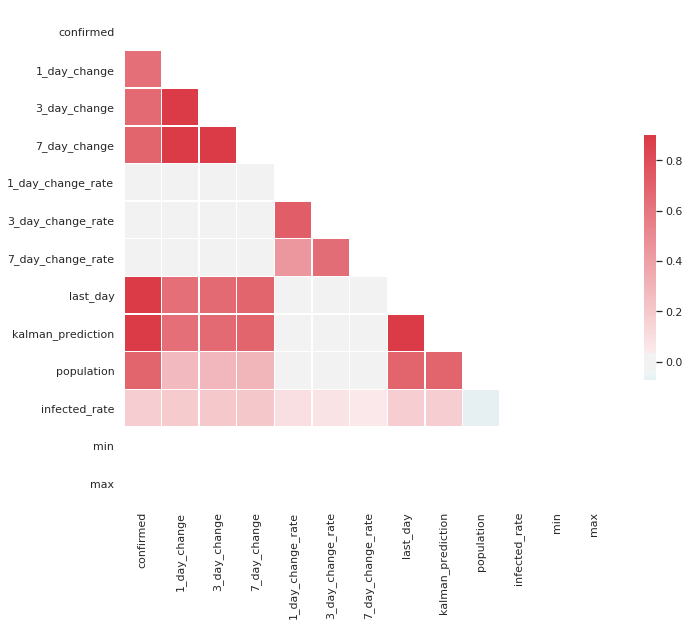

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.632938
3_day_change         0.670893
7_day_change         0.689434
1_day_change_rate    0.018566
3_day_change_rate    0.010400
7_day_change_rate    0.000705
last_day             0.992466
kalman_prediction    0.993695
population           0.684167
infected_rate        0.175610
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


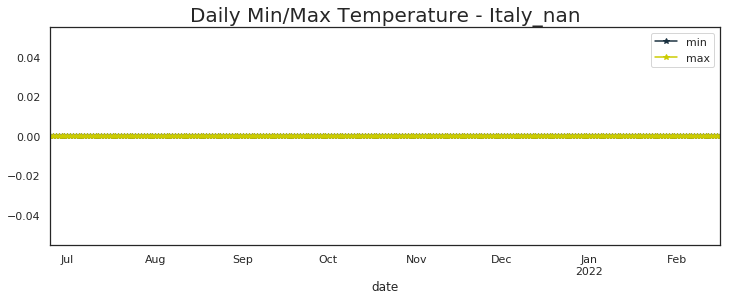

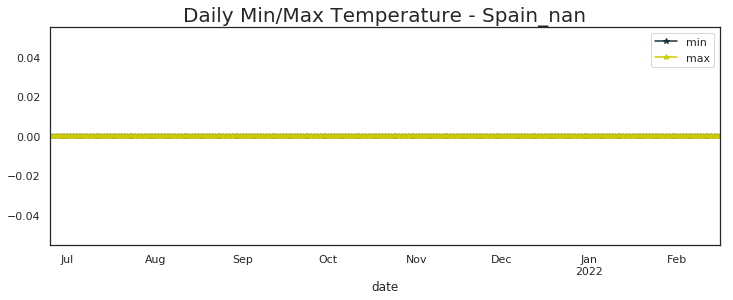

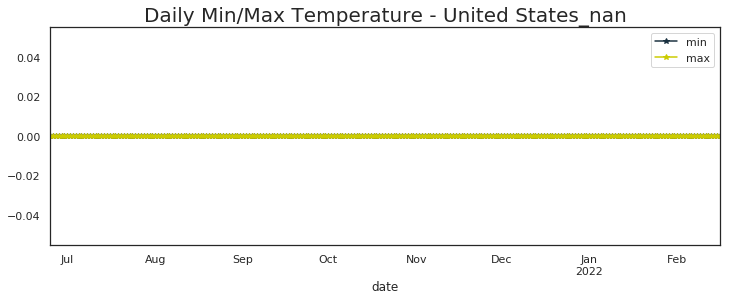

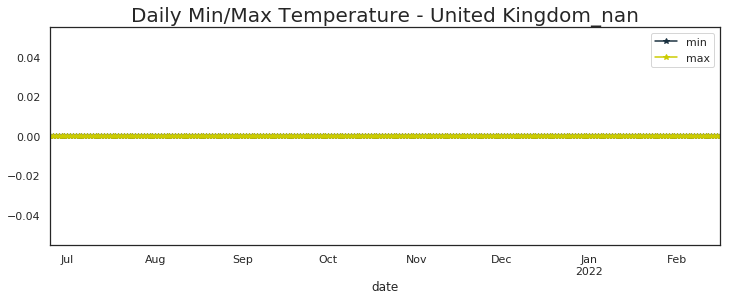

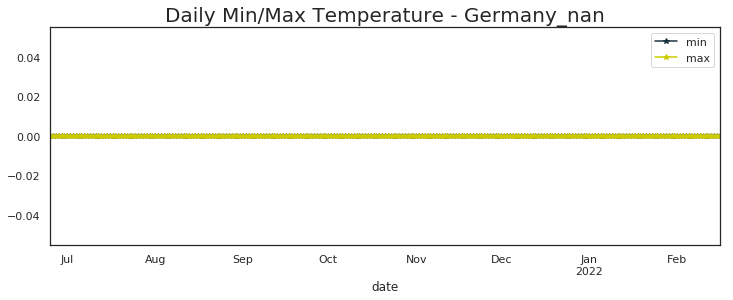

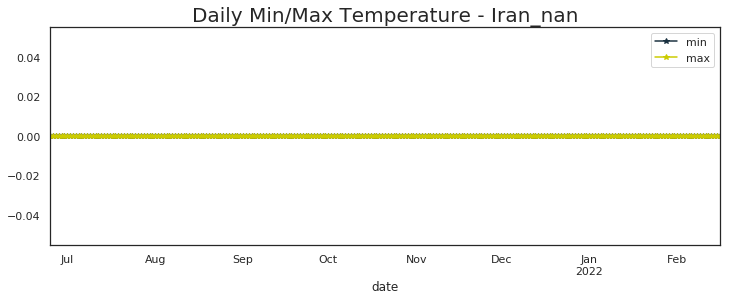

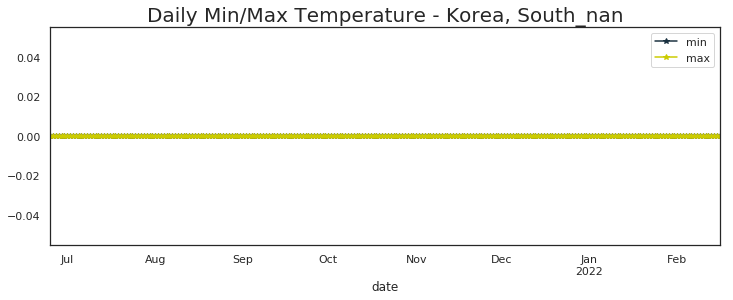

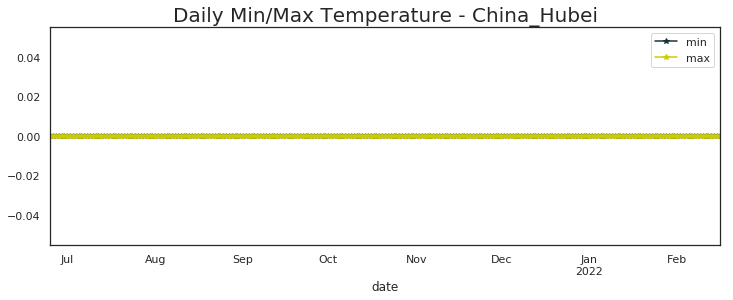

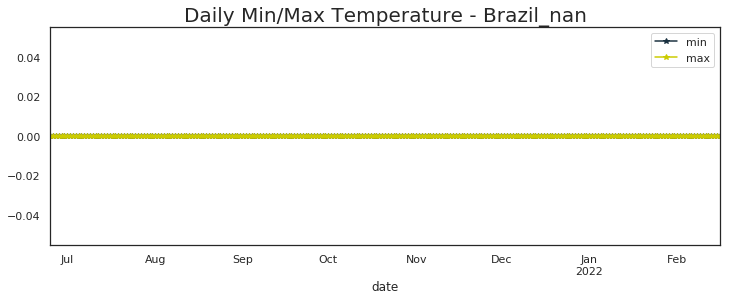

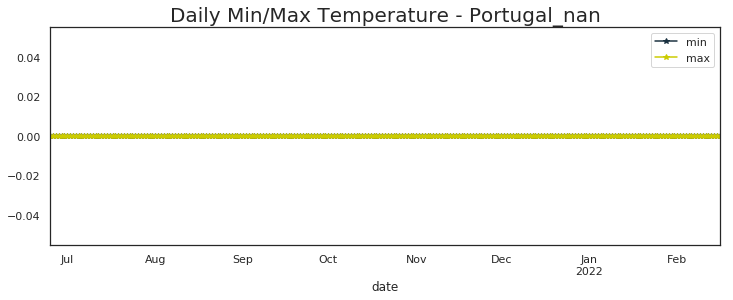

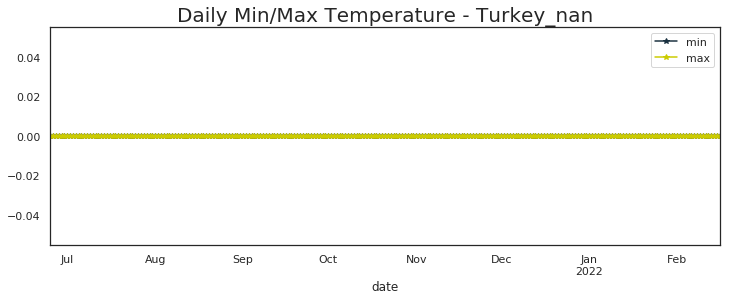

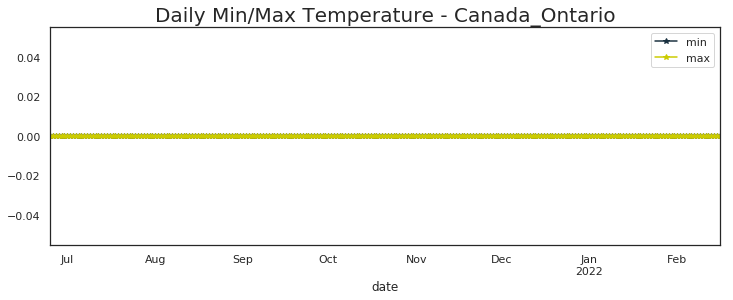

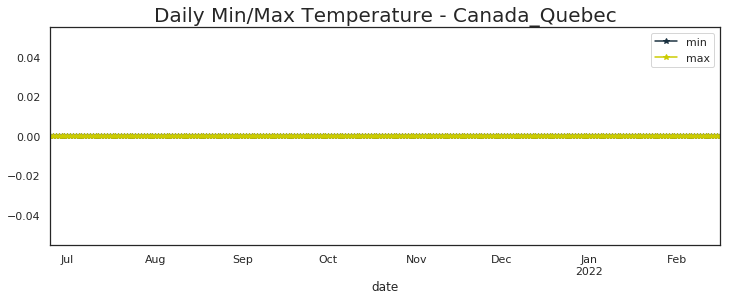

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
France_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
Germany_nan                 0.0  0.0
Italy_nan                   0.0  0.0
Spain_nan                   0.0  0.0
Argentina_nan               0.0  0.0
Iran_nan                    0.0  0.0
Colombia_nan                0.0  0.0
Netherlands_nan             0.0  0.0
Poland_nan                  0.0  0.0
Mexico_nan                  0.0  0.0
Indonesia_nan               0.0  0.0
Ukraine_nan                 0.0  0.0
Japan_nan                   0.0  0.0
South Africa_nan            0.0  0.0
Philippines_nan             0.0  0.0
Israel_nan                  0.0  0.0
Belgium_nan                 0.0  0.0
Peru_nan                    0.0  0.0
Cz

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

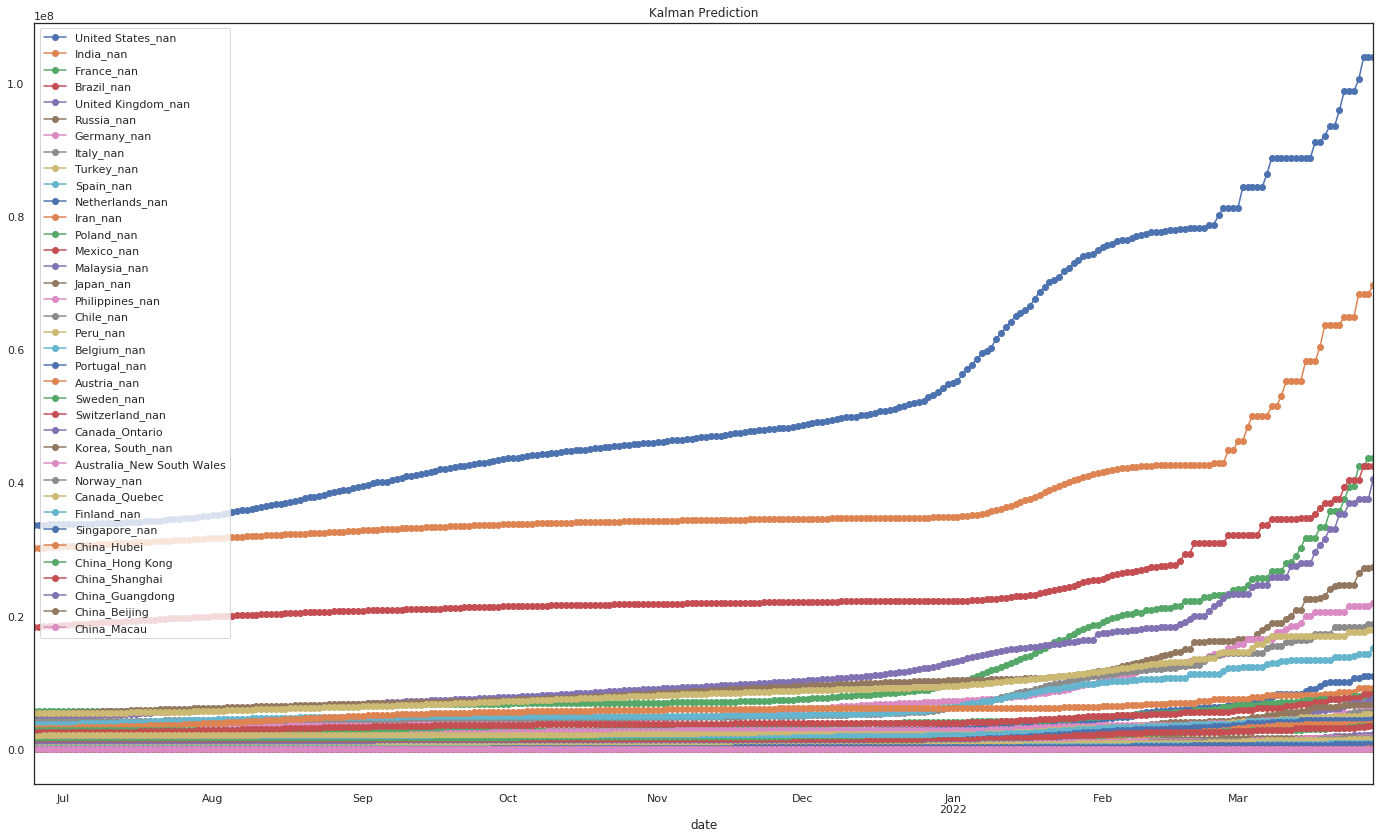

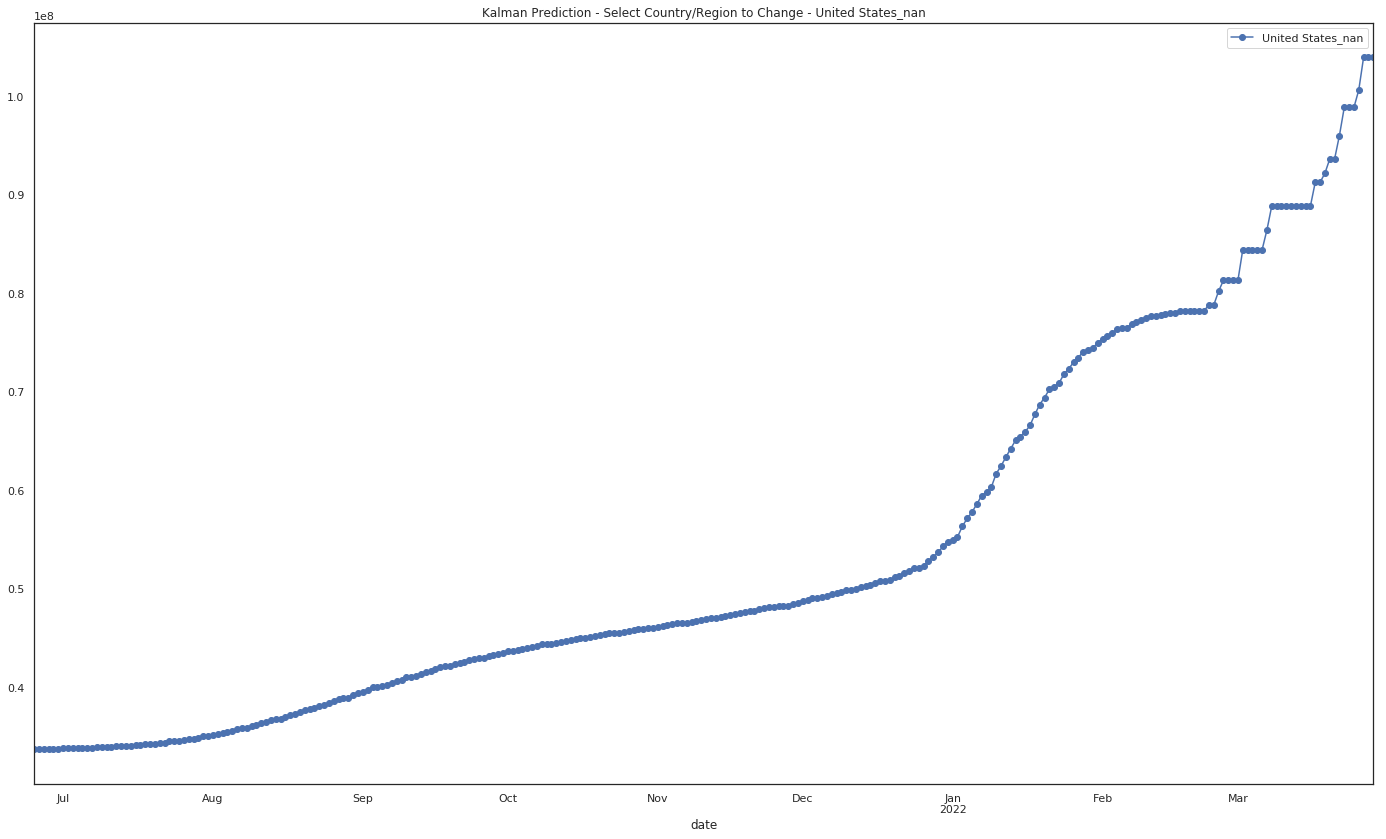

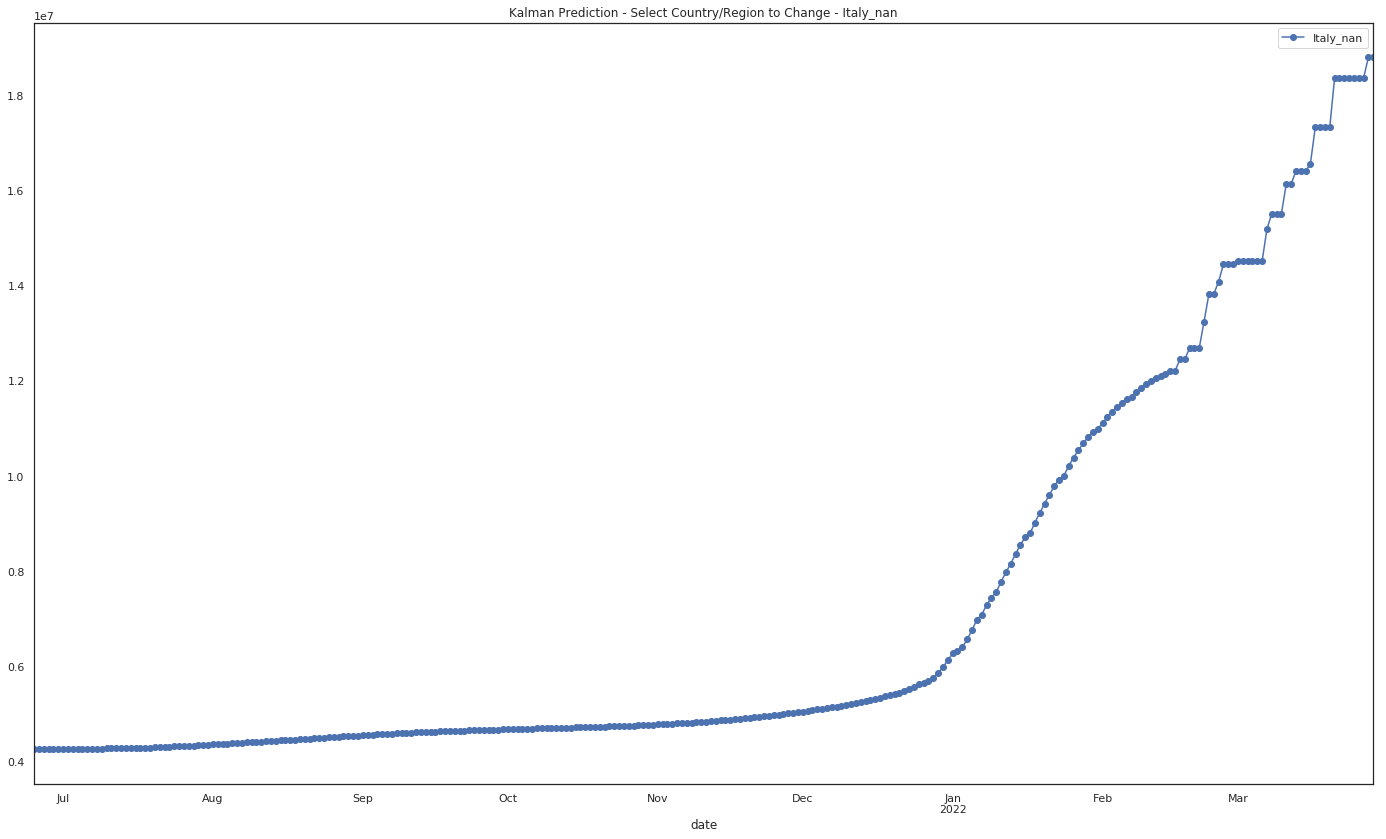

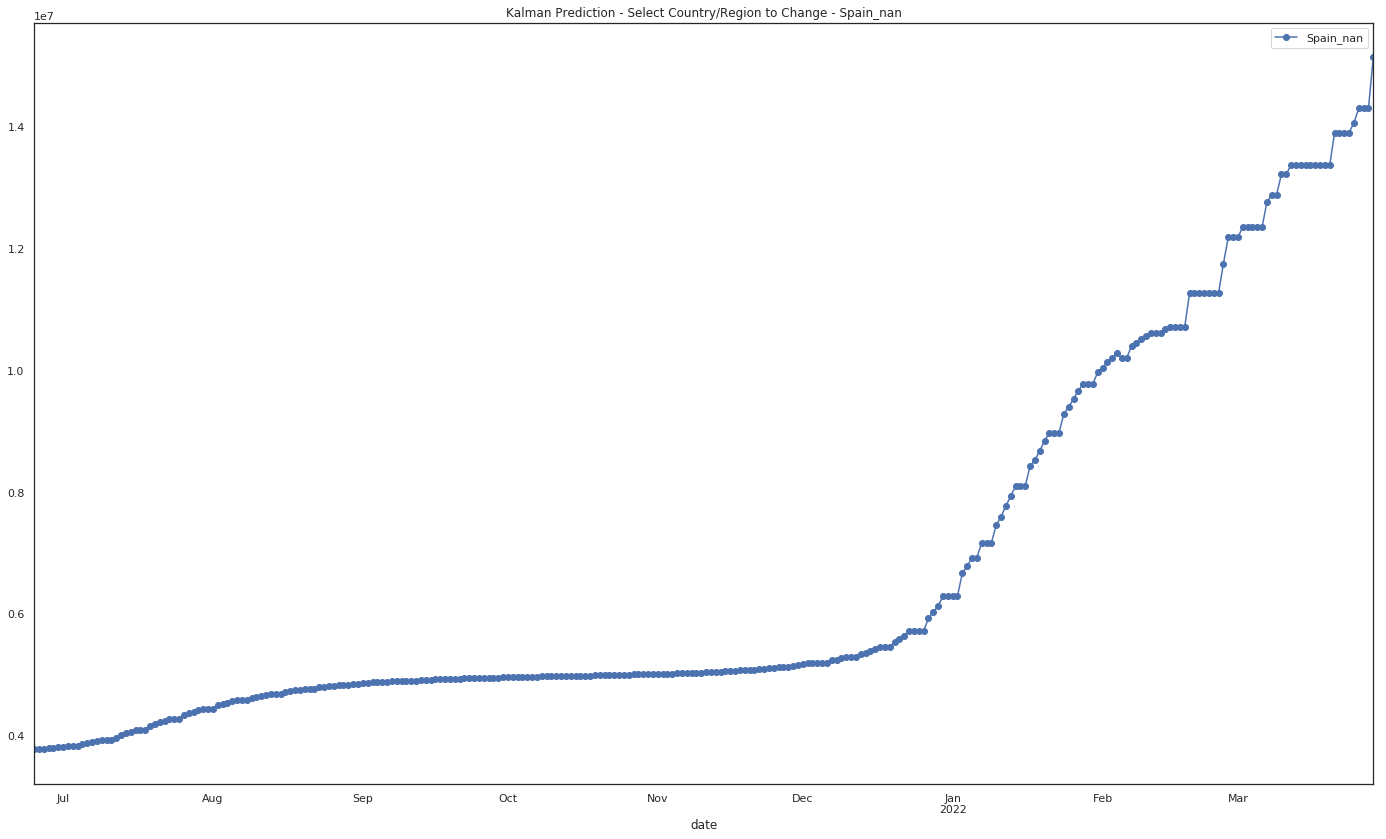

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


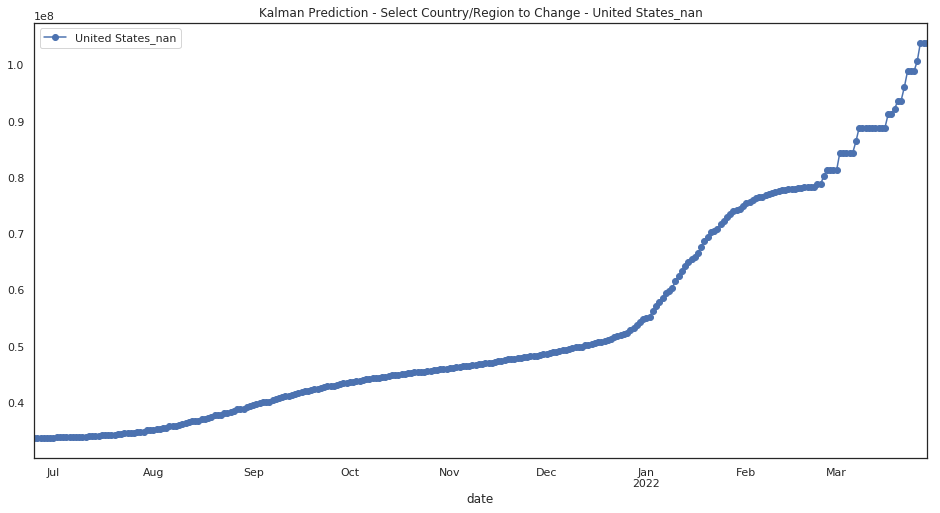

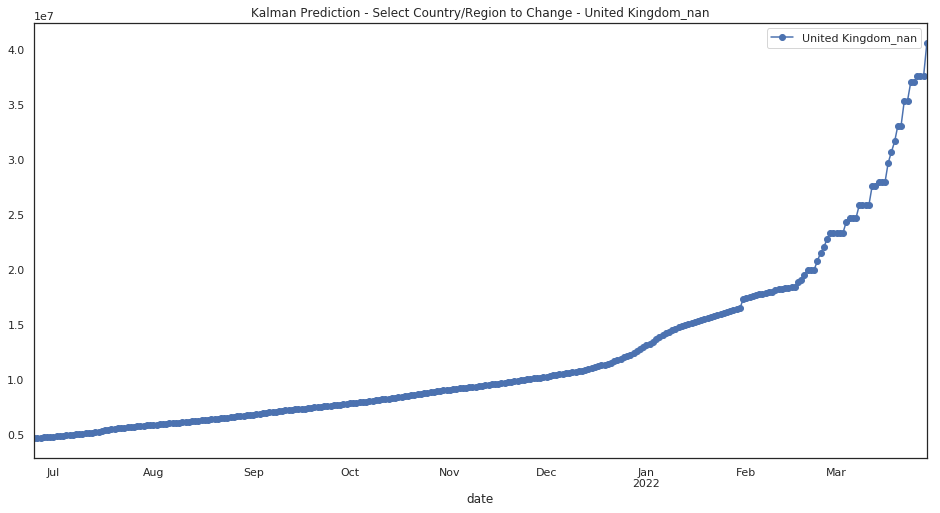

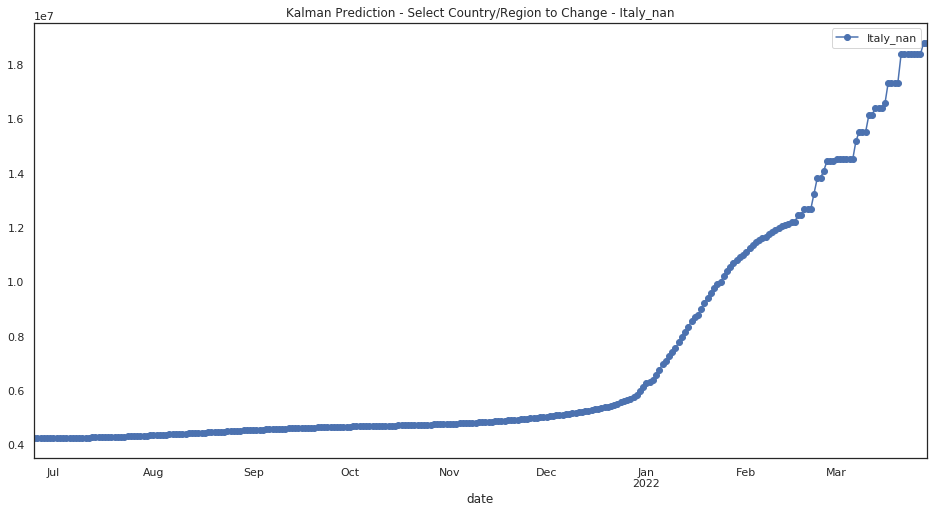

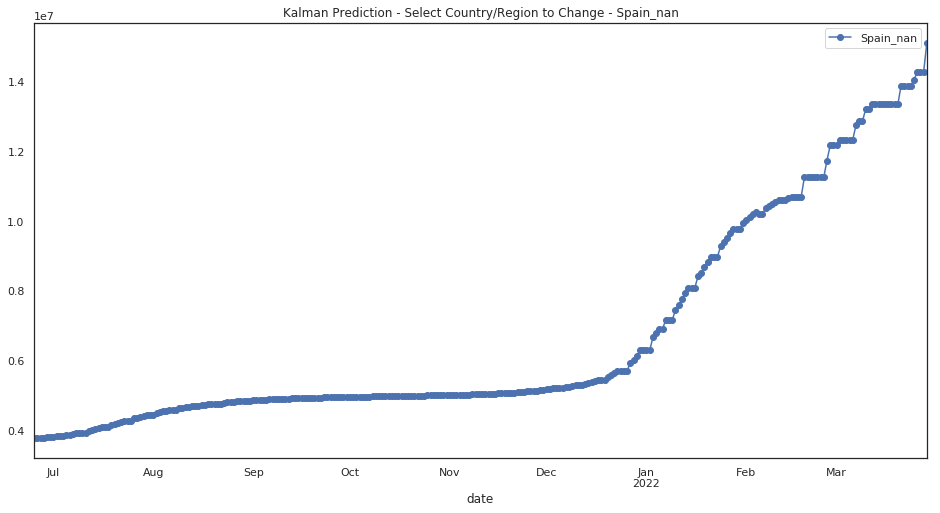

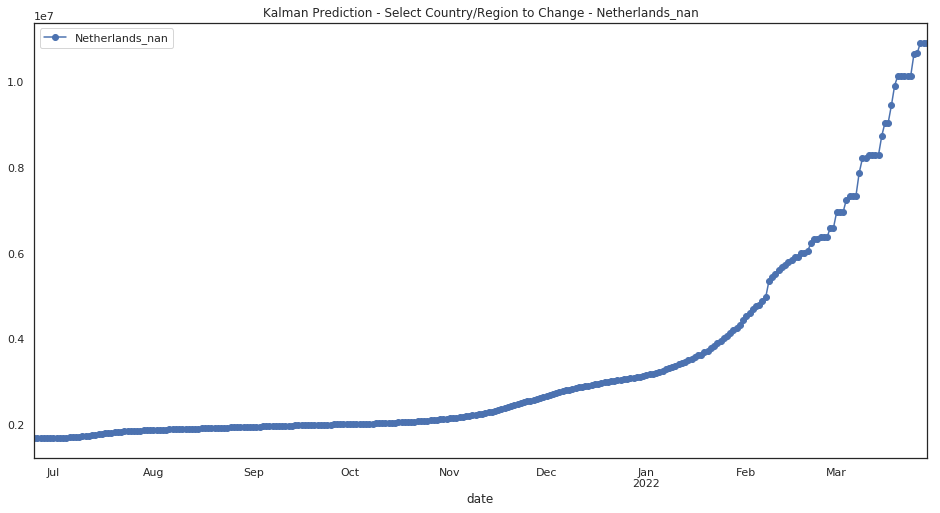

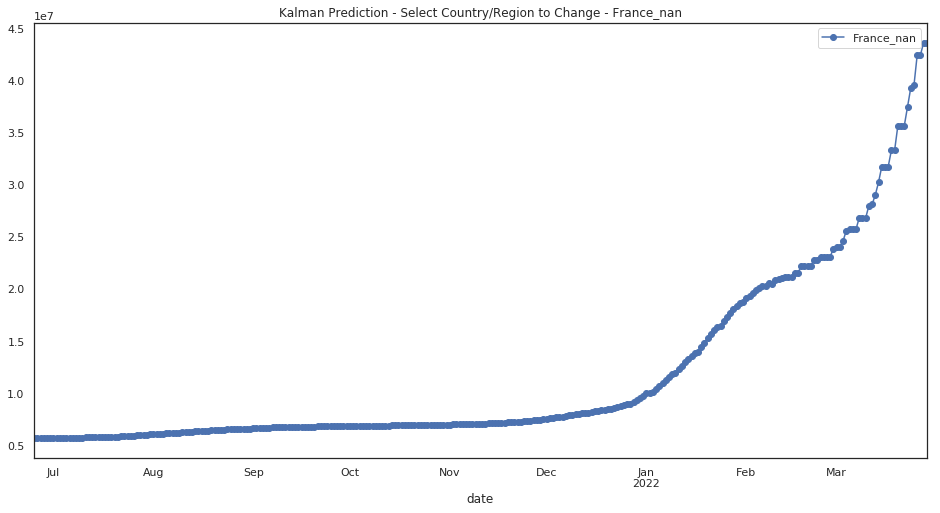

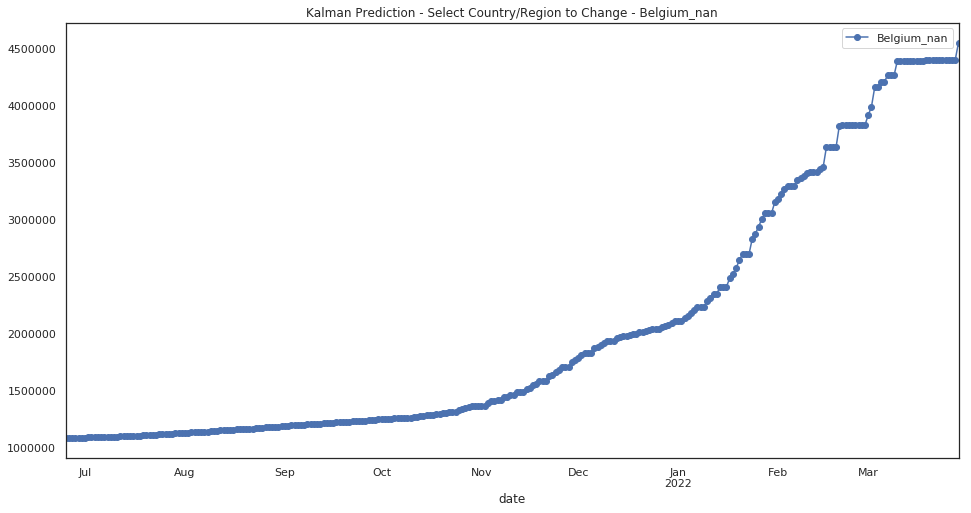

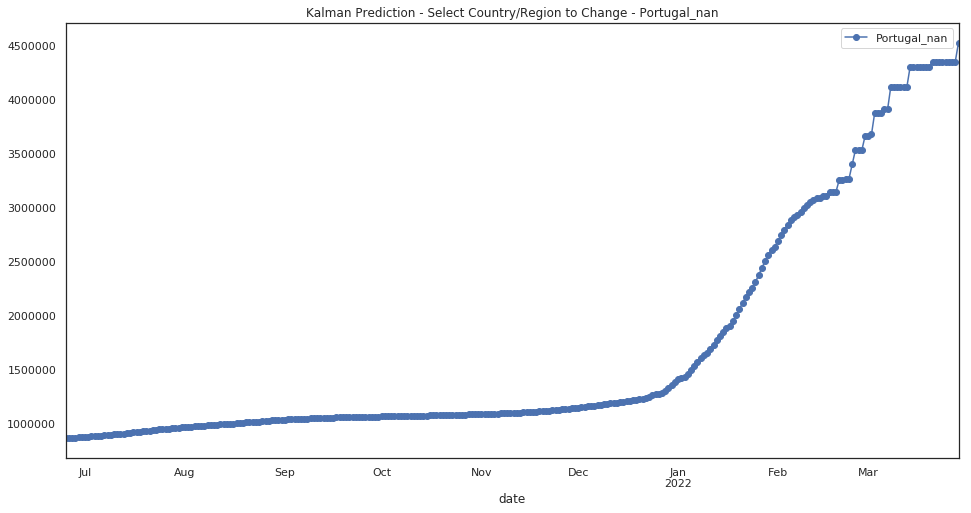

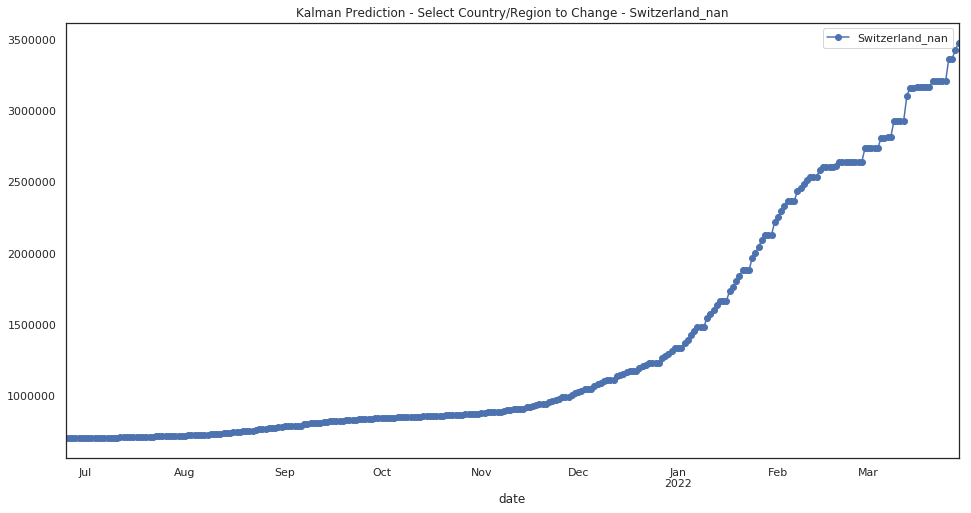

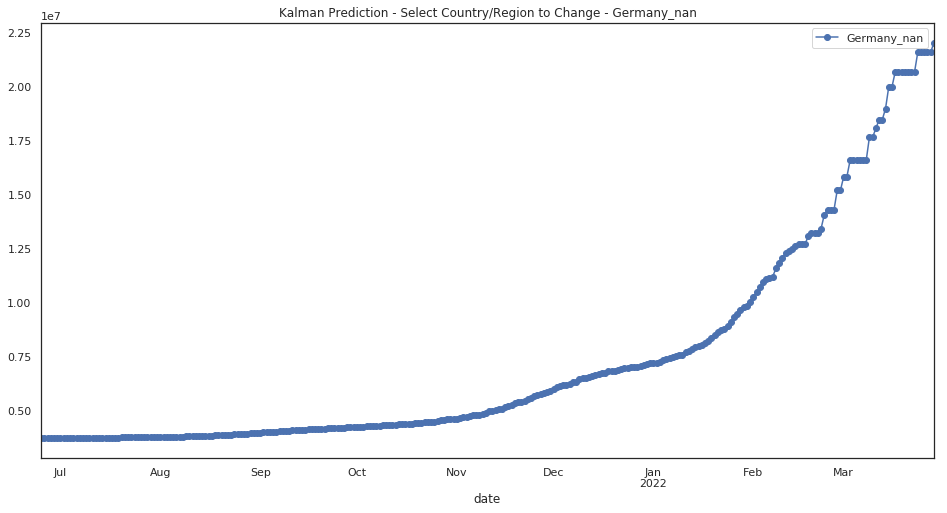

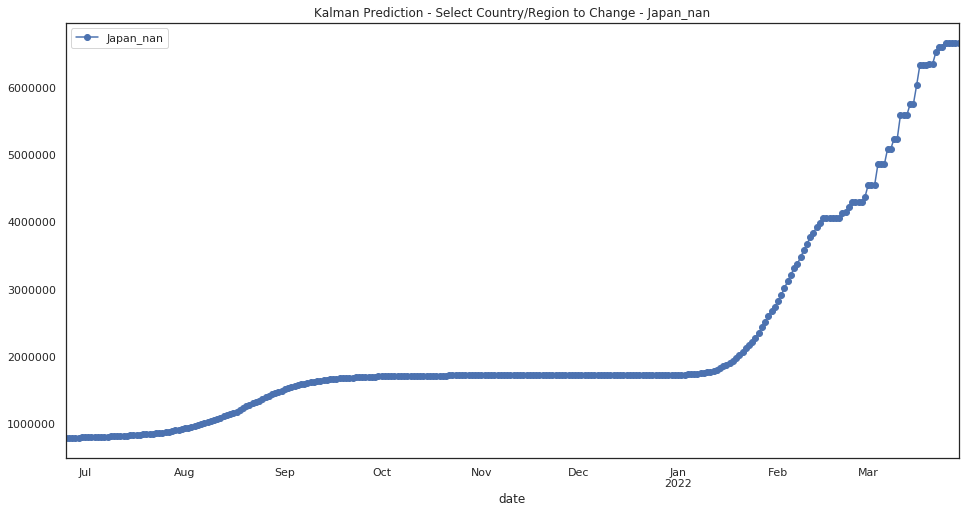

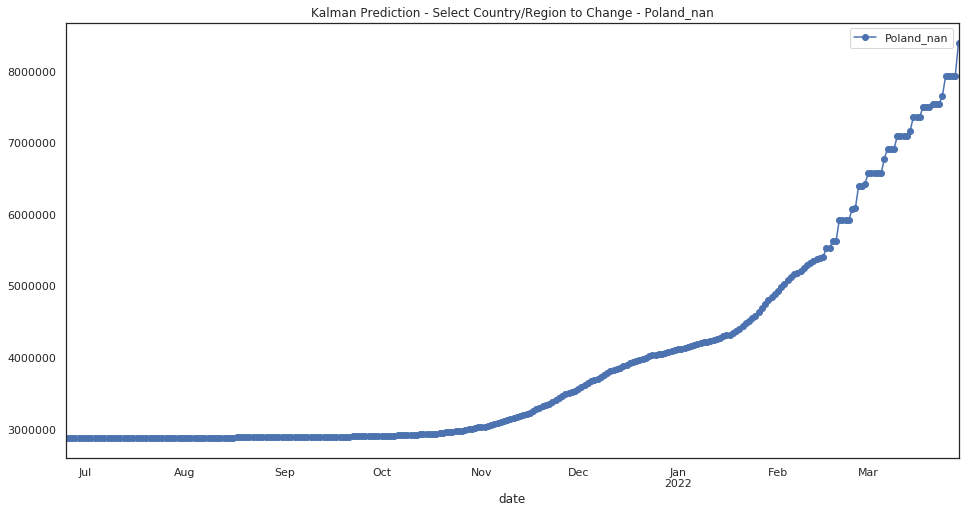

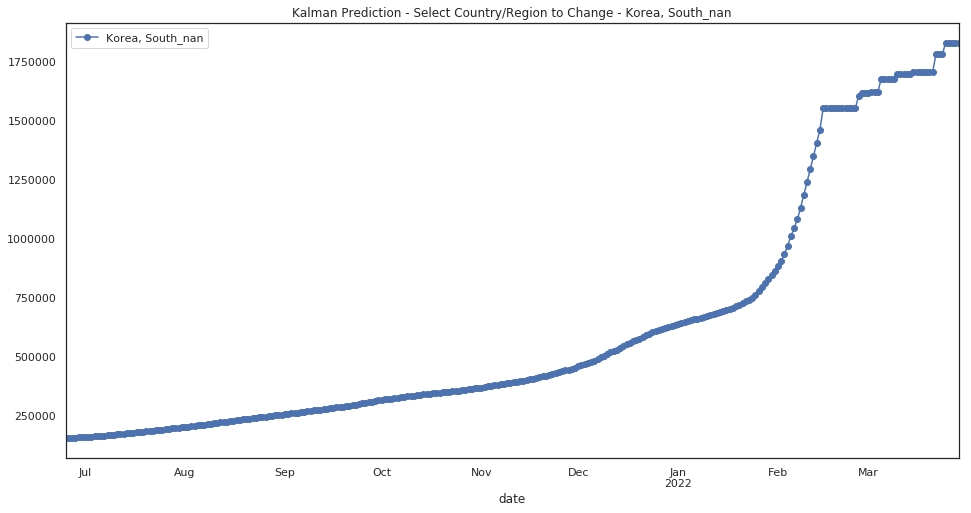

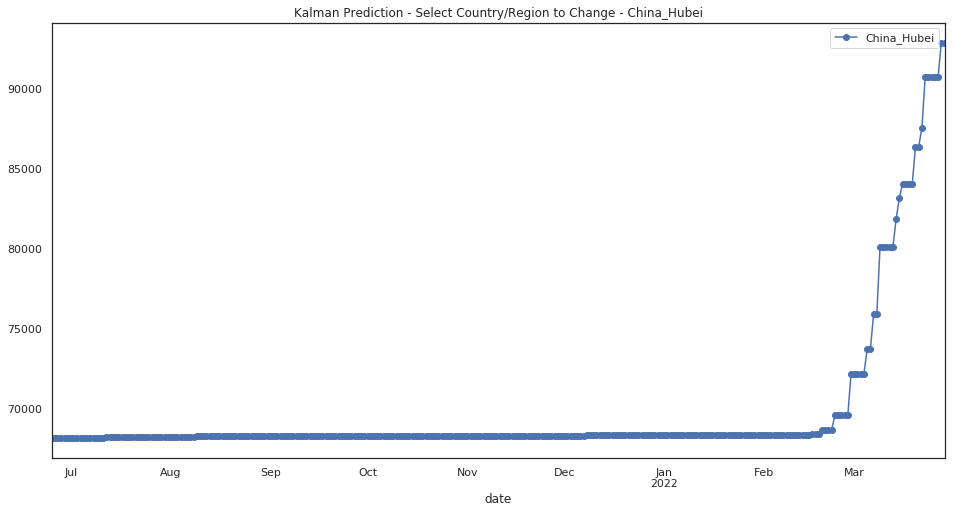

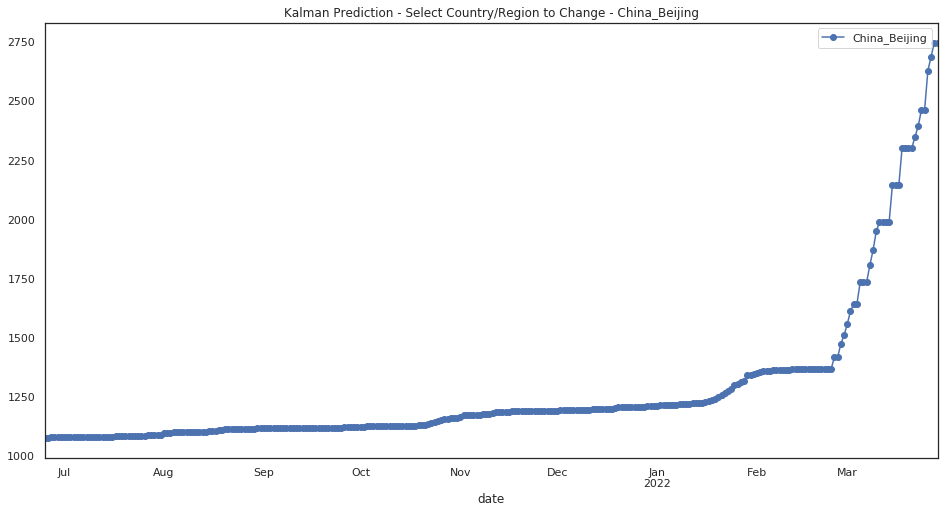

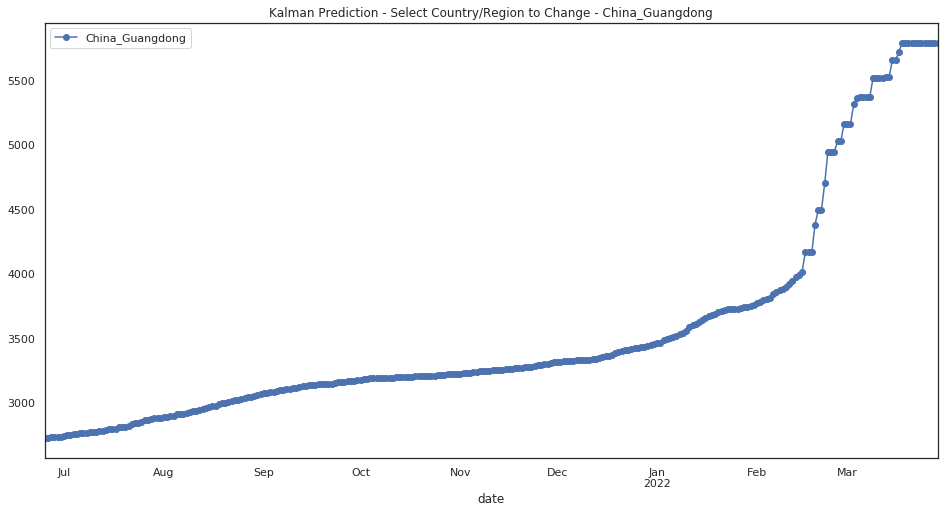

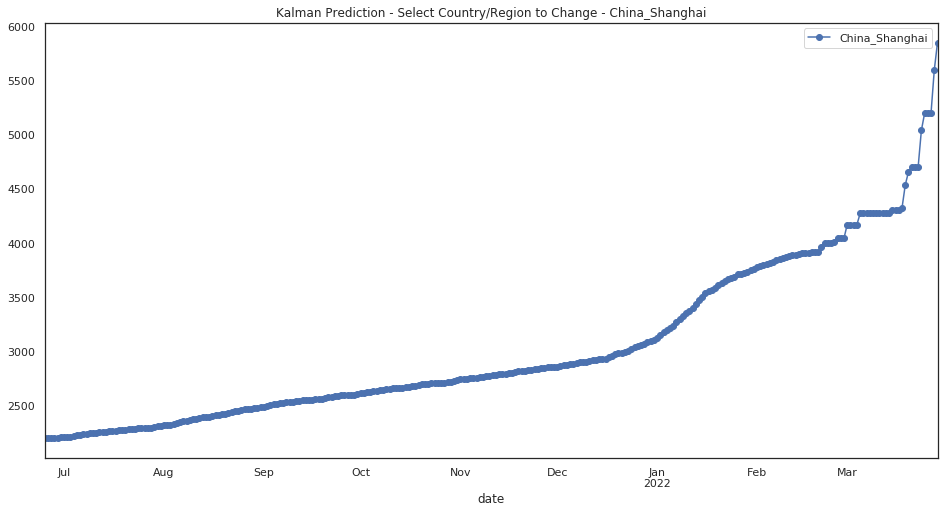

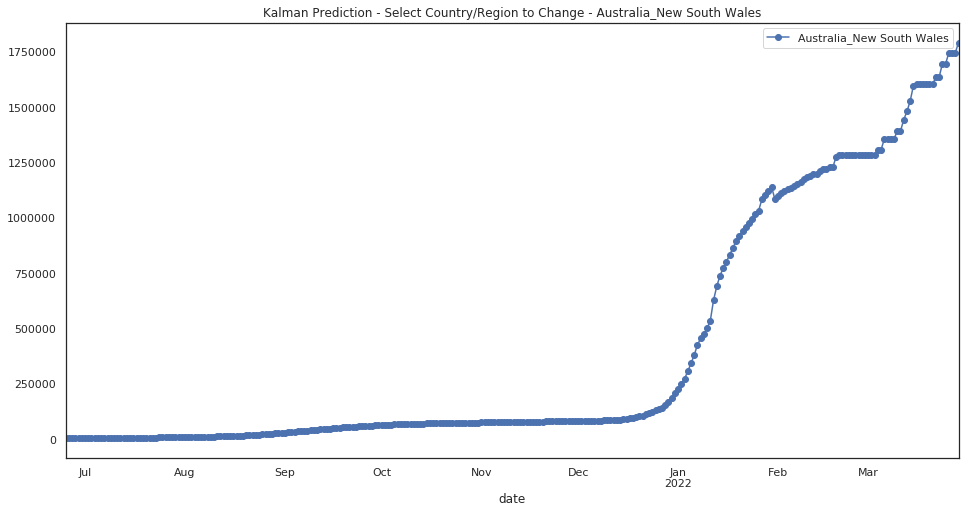

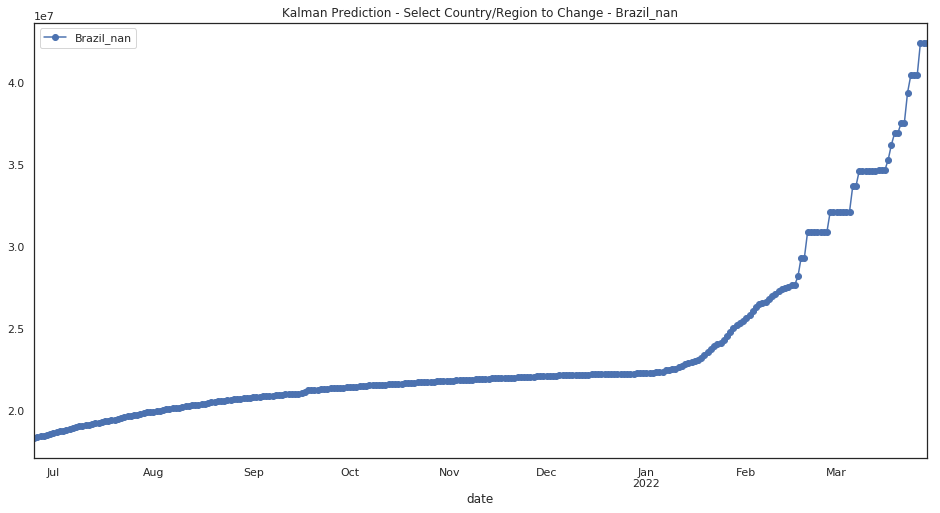

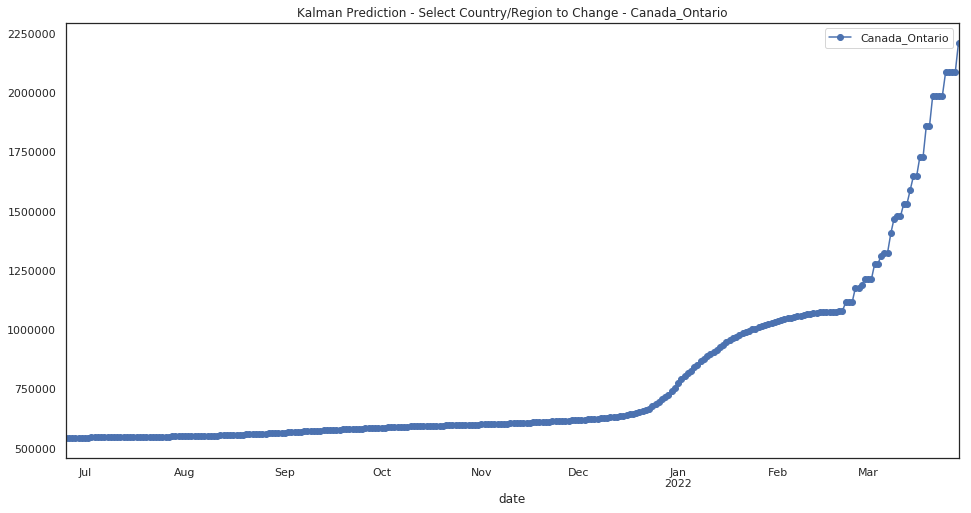

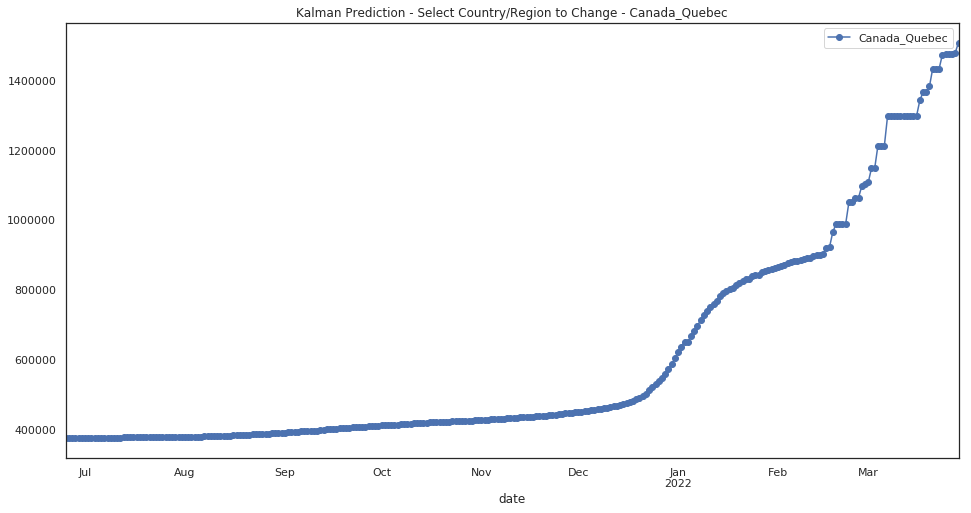

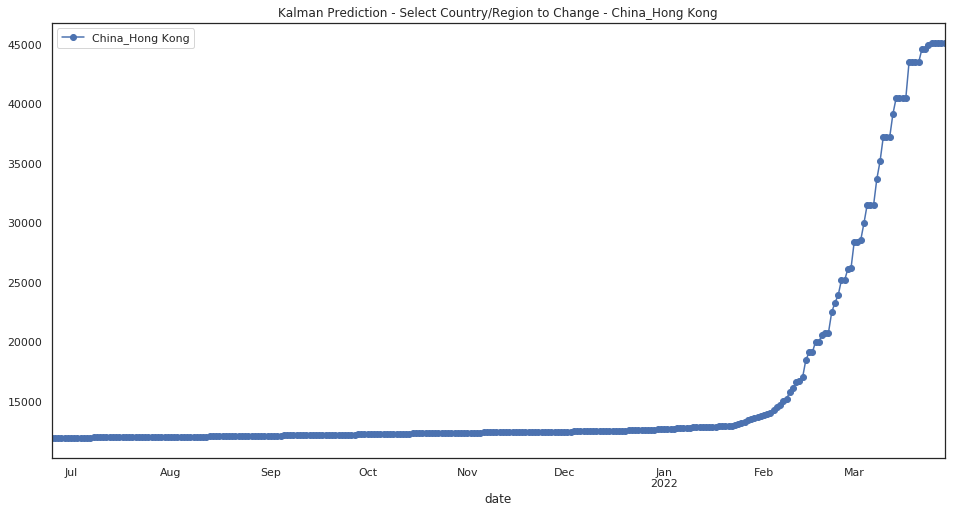

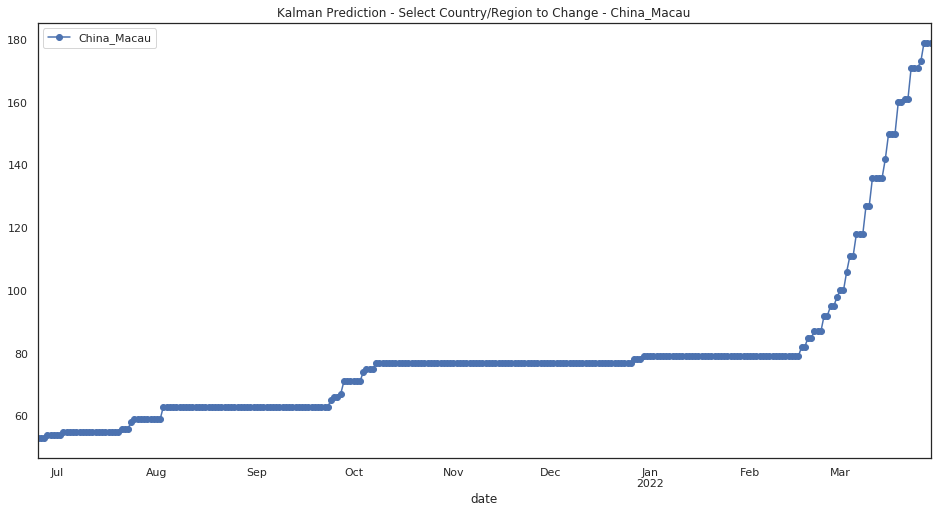

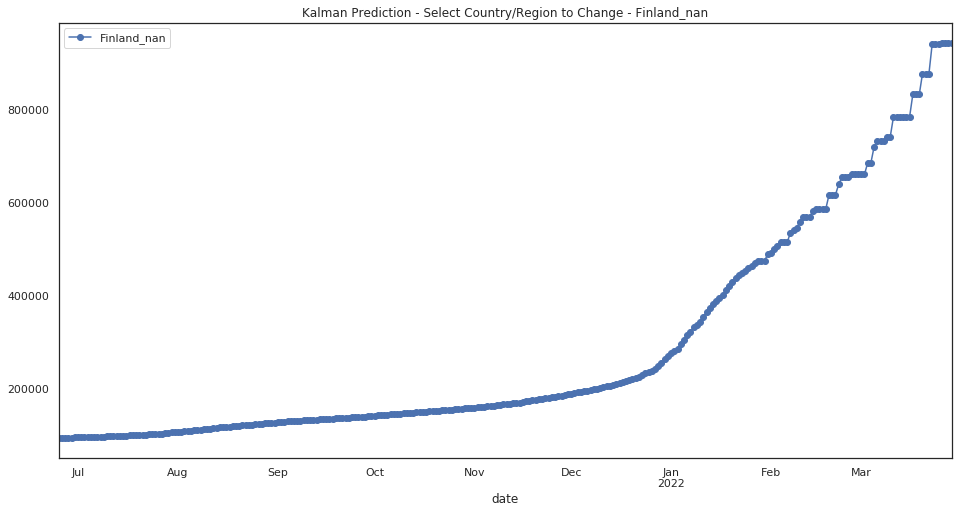

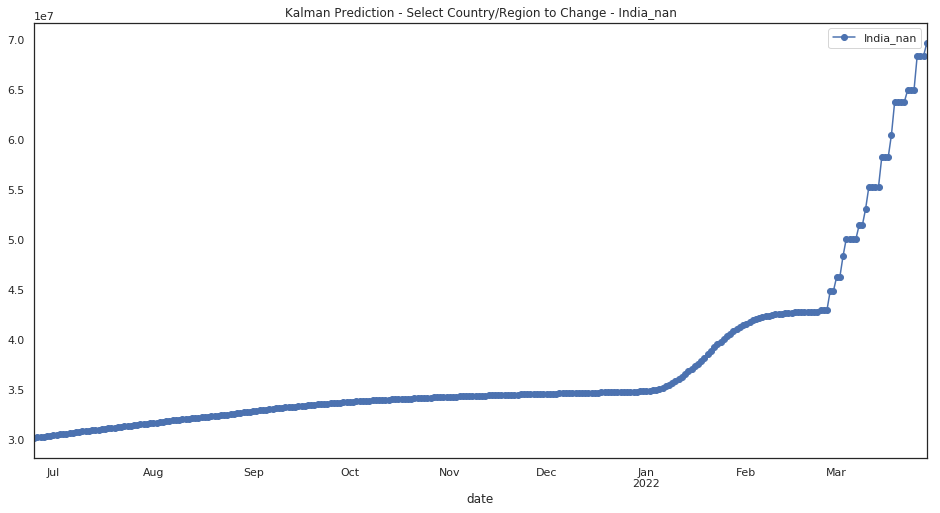

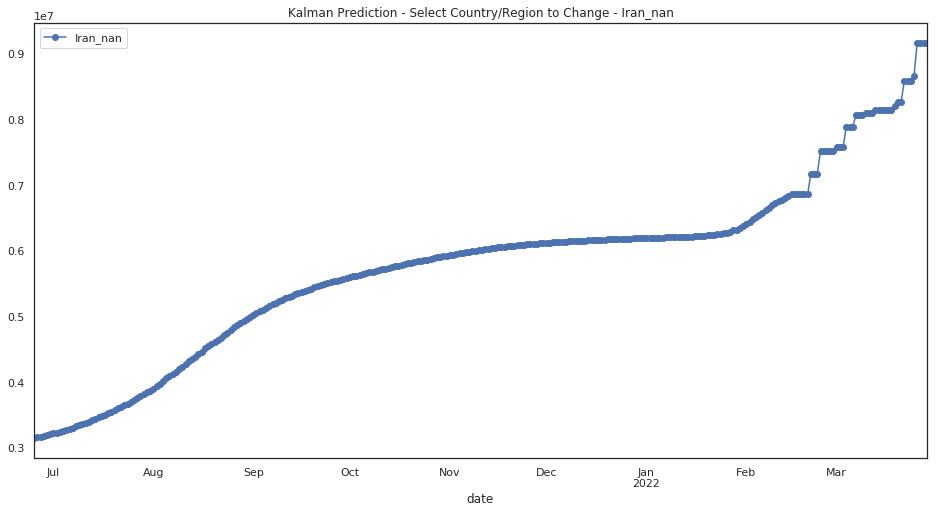

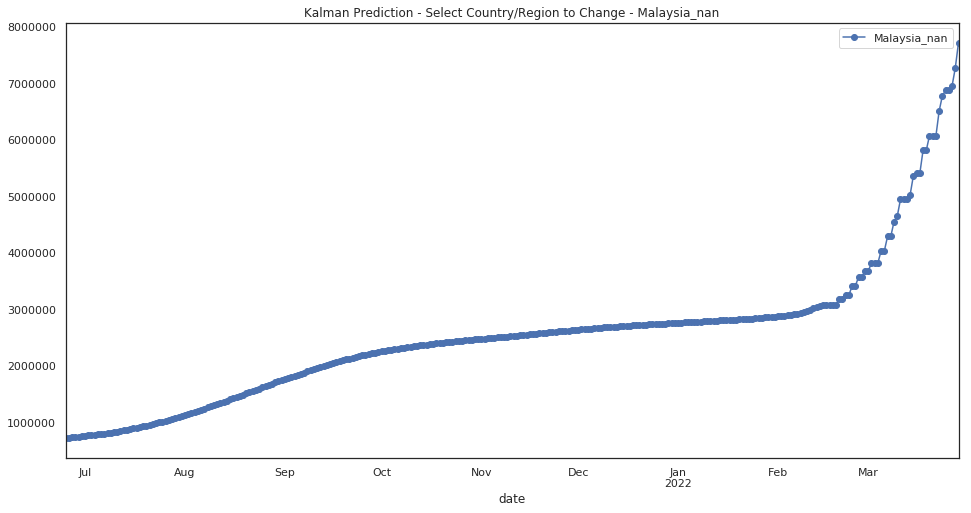

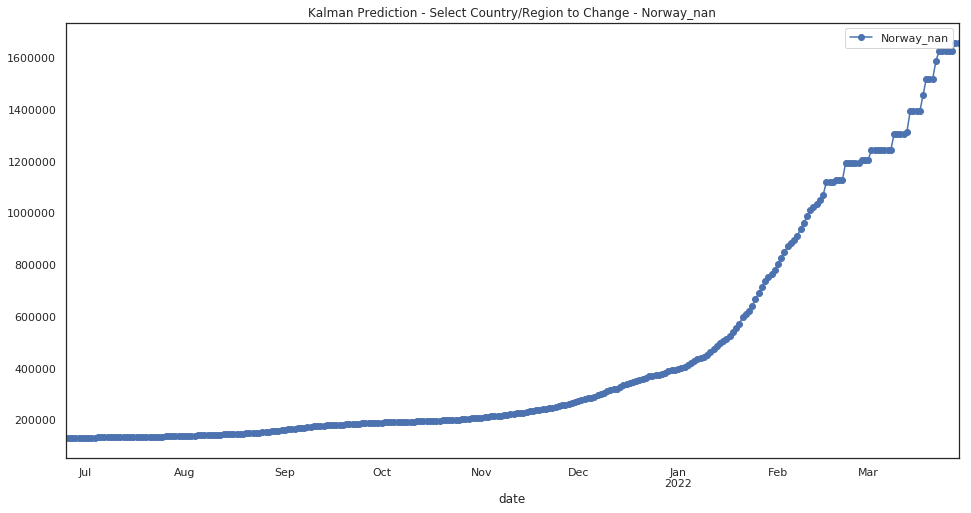

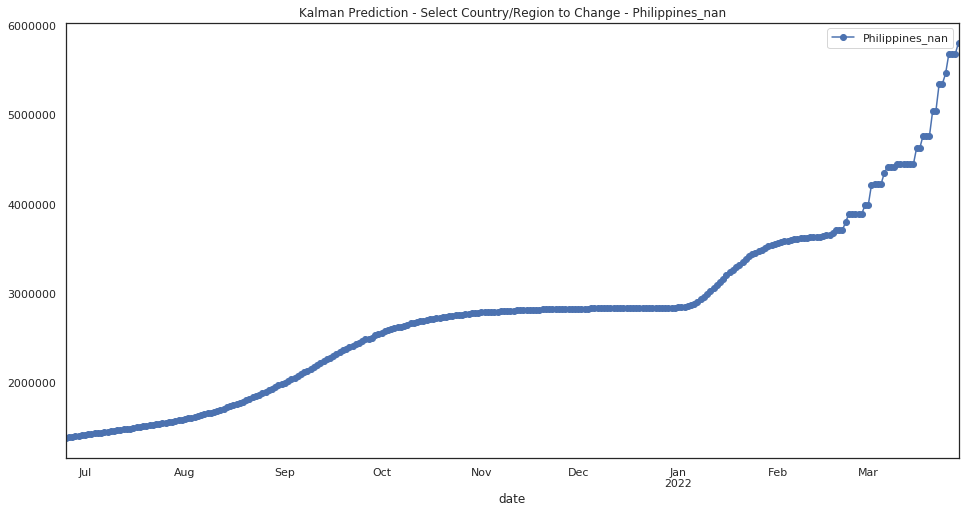

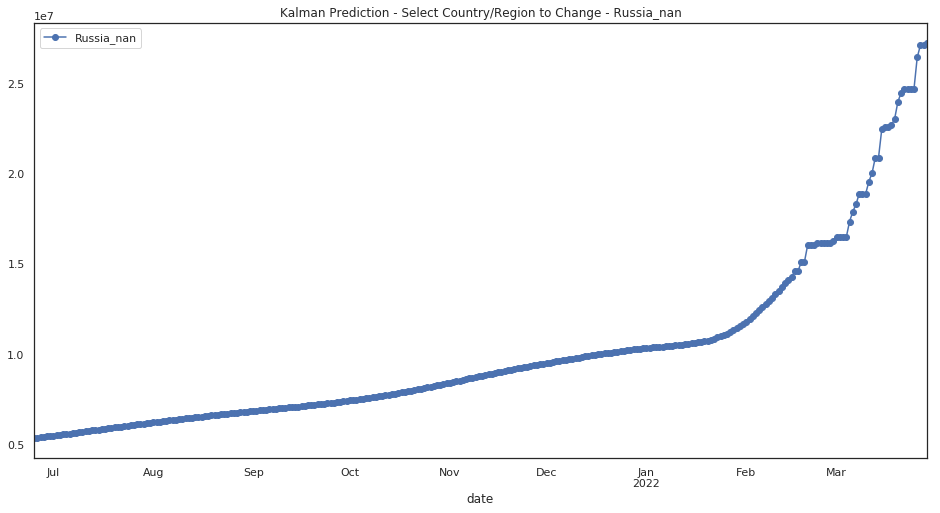

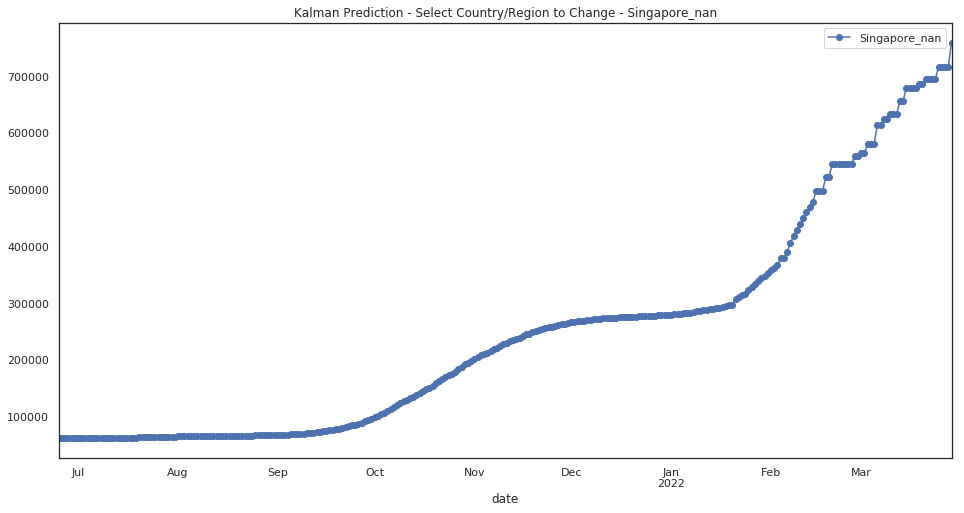

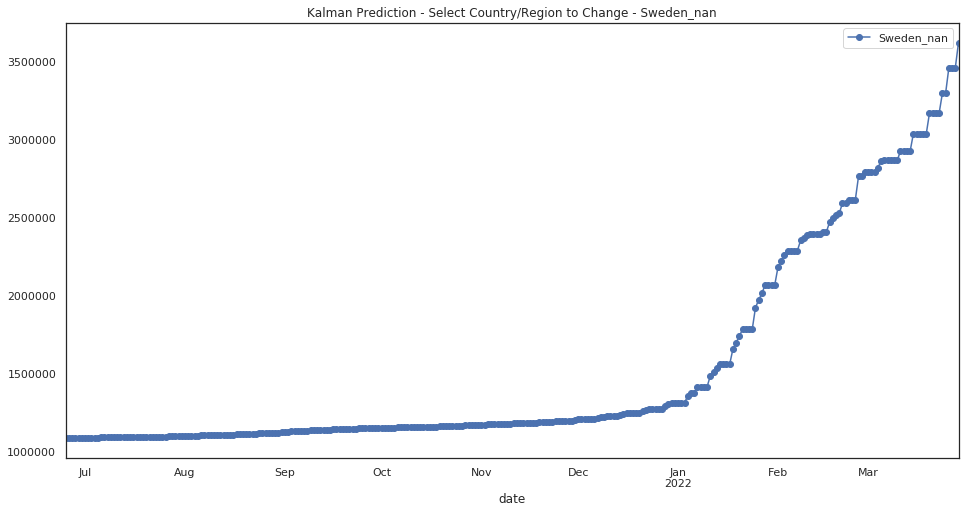

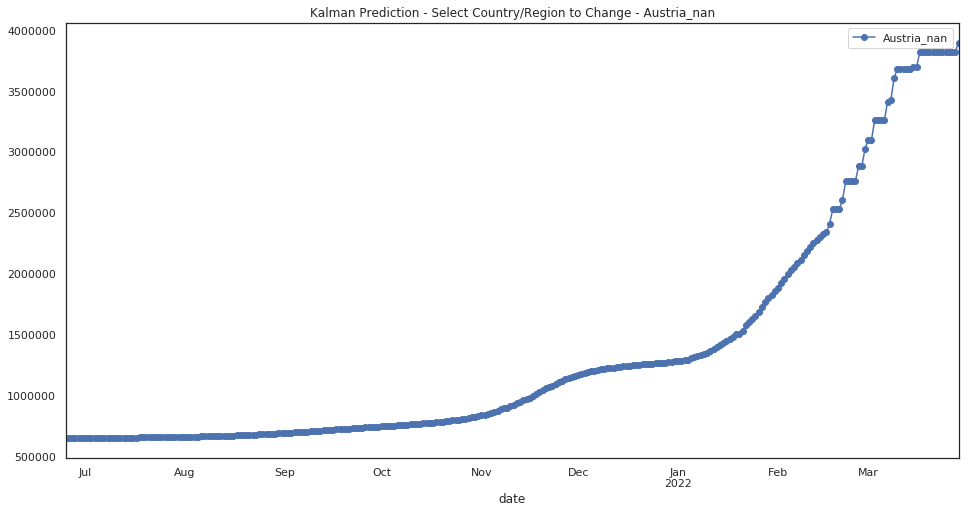

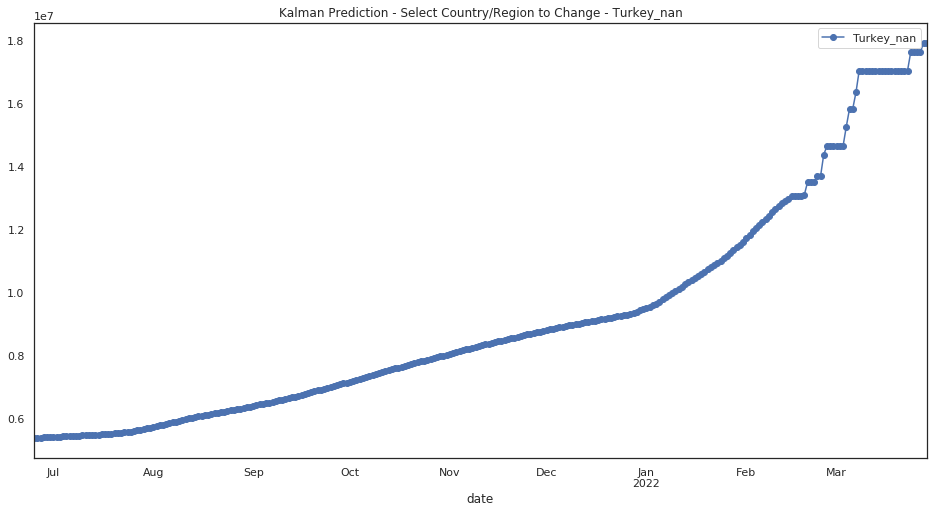

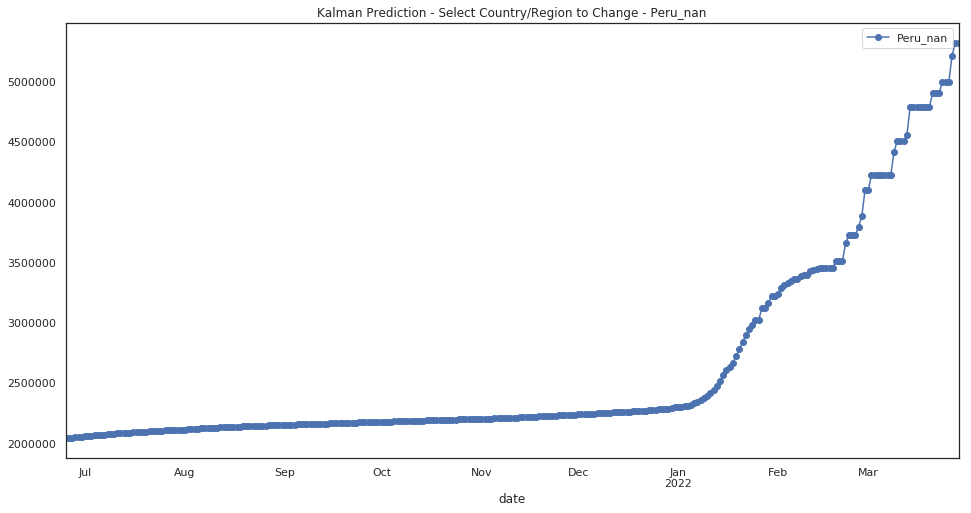

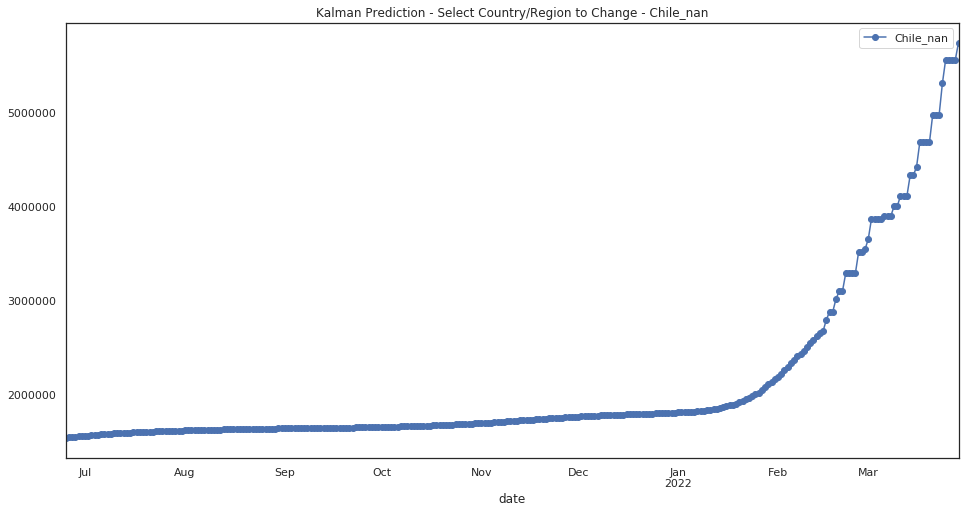

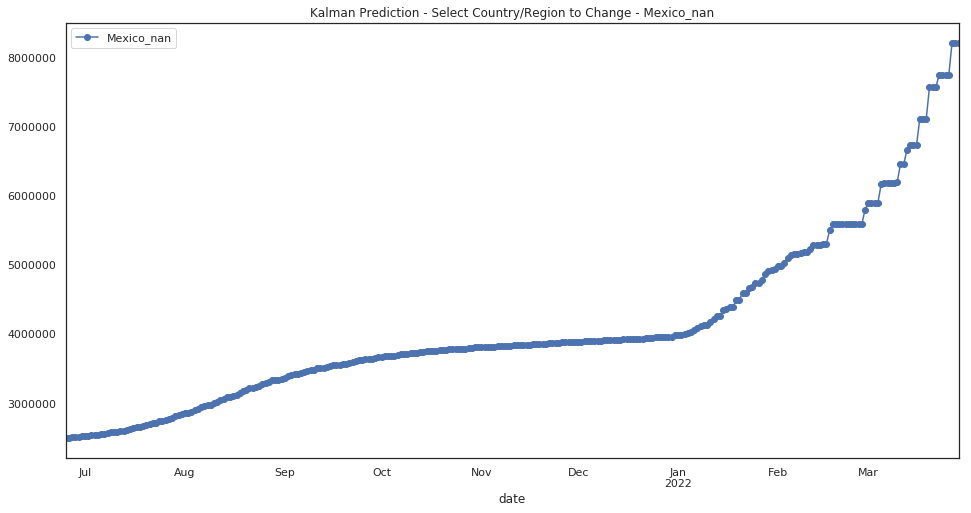

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-03-29 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     103960635.0
India_nan                                           NaN      69745060.0
France_nan                                          NaN      43684949.0
Brazil_nan                                          NaN      42471286.0
United Kingdom_nan                                  NaN      40610509.0
Russia_nan                                          NaN      27300749.0
Germany_nan                                         NaN      22024958.0
Italy_nan                                           NaN      18804856.0
Turkey_nan                                          NaN      17926113.0
Spain_nan                                           NaN      15132055.0
Argentina_nan                                       NaN      14149868.0
Netherlands_nan                                     NaN      10921188.0
Iran_nan                                            NaN       9172112.0
Colombia_nan                                        NaN       9077667.0
Poland_nan                                          NaN       8400110.0
Mexico_nan                                          NaN       8212992.0
Malaysia_nan                                        NaN       7723676.0
Indonesia_nan                                       NaN       7192066.0
Ukraine_nan                                         NaN       6981598.0
Japan_nan                                           NaN       6664193.0
Czechia_nan                                         NaN       6608842.0
Philippines_nan                                     NaN       5812179.0
Chile_nan                                           NaN       5748339.0
South Africa_nan                                    NaN       5713276.0
Peru_nan                                            NaN       5323892.0
Vietnam_nan                                         NaN       5312567.0
Israel_nan                                          NaN       4975181.0
Belgium_nan                                         NaN       4555552.0
Portugal_nan                                        NaN       4525788.0
Iraq_nan                                            NaN       3957205.0
...                                                 ...             ...
Diamond Princess_nan                                NaN          1389.0
China_Anhui                                         NaN          1379.0
China_Jilin                                         NaN          1176.0
China_Chongqing                                     NaN           956.0
France_Wallis and Futuna                            NaN           942.0
Tonga_nan                                           NaN           811.0
China_Gansu                                         NaN           784.0
Winter Olympics 2022_nan                            NaN           731.0
China_Shanxi                                        NaN           392.0
United Kingdom_Montserrat                           NaN           290.0
China_Guizhou                                       NaN           260.0
China_Hainan                                        NaN           224.0
China_Macau                                         NaN           179.0
United Kingdom_Falkland Islands (Malvinas)          NaN           176.0
China_Ningxia                                       NaN           162.0
China_Unknown                                       NaN           105.0
China_Qinghai                                       NaN            68.0
Samoa_nan                                           NaN            47.0
Holy See_nan                                        NaN            43.0
Canada_Grand Princess                               NaN            21.0
Canada_Repatriated Travellers                       NaN            17.0
Antarctica_nan                                      NaN            11.0
MS Zaandam_nan                                      NaN             9.0
Vanuatu_nan                                         NaN             7.0
Marshall Islands_nan  

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-06-25         174660.0     192606.0     197125.0      90813.0   
2021-06-26         175974.0     192609.0     197418.0      90813.0   
2021-06-27         113124.0     132509.0     138113.0      13882.0   
2021-06-28         114220.0     132512.0     138465.0      13882.0   
2021-06-29         116651.0     132513.0     138863.0      13882.0   
2021-06-30         118152.0     132514.0     139261.0      13900.0   
2021-07-01         119720.0     132521.0     139705.0      13911.0   
2021-07-02         121616.0     132523.0     140183.0      13918.0   
2021-07-03         124699.0     133847.0     142712.0      13918.0   
2021-07-04         125995.0     133849.0     143169.0      13918.0   
2021-07-05         127182.0     133851.0     143654.0      13918.0   
2021-07-06         128662.0     133857.0     144134.0      13918.0   
2021-07-07         130222.0     133869.0     144698.0      13991.0   
2021-07-08         131393.0     133878.0     145315.0      14021.0   
2021-07-09         132828.0     133892.0     146113.0      14050.0   
2021-07-10         134100.0     133899.0     146937.0      14075.0   
2021-07-11         134948.0     133904.0     147696.0      14075.0   
2021-07-12         135987.0     133909.0     148541.0      14075.0   
2021-07-13         137211.0     133918.0     149464.0      14155.0   
2021-07-14         138063.0     133927.0     150367.0      14167.0   
2021-07-15         139226.0     133939.0     151431.0      14167.0   
2021-07-16         140453.0     133957.0     152616.0      14239.0   
2021-07-17         141648.0     133975.0     153734.0      14273.0   
2021-07-18         142152.0     133995.0     154813.0      14273.0   
2021-07-19         142916.0     134007.0     155961.0      14273.0   
2021-07-20         143875.0     134044.0     157236.0      14359.0   
2021-07-21         144318.0     134070.0     158470.0      14379.0   
2021-07-22         144702.0     134101.0     159657.0      14379.0   
2021-07-23         145022.0     134132.0     160983.0      14464.0   
2021-07-24         145276.0     134156.0     162309.0      14498.0   
...                     ...          ...          ...          ...   
2022-03-01         211480.0     296157.0     272205.0      41903.0   
2022-03-02         209783.0     293459.0     272438.0      41903.0   
2022-03-03         209639.0     309346.0     272438.0      41903.0   
2022-03-04         210023.0     317373.0     272438.0      41903.0   
2022-03-05         213663.0     318415.0     272438.0      41903.0   
2022-03-06         223762.0     322829.0     272438.0      41903.0   
2022-03-07         226806.0     321575.0     272438.0      41903.0   
2022-03-08         225874.0     321575.0     272438.0      41903.0   
2022-03-09         226468.0     321575.0     272438.0      41903.0   
2022-03-10         225764.0     322907.0     272438.0      41935.0   
2022-03-11         225764.0     325734.0     272438.0      41935.0   
2022-03-12         225733.0     324813.0     272438.0      41935.0   
2022-03-13         226004.0     325014.0     272438.0      43838.0   
2022-03-14         229358.0     324965.0     272438.0      43838.0   
2022-03-15         230615.0     324965.0     279365.0      43838.0   
2022-03-16         229768.0     324965.0     283039.0      43838.0   
2022-03-17         236813.0     324965.0     280098.0      43838.0   
2022-03-18         240056.0     325186.0     281732.0      43838.0   
2022-03-19         237528.0     325186.0     282481.0      44289.0   
2022-03-20         237528.0     338831.0     281771.0      44289.0   
2022-03-21         237378.0     346754.0     284438.0      44289.0   
2022-03-22         237583.0     340715.0     285853.0      44356.0   
2022-03-23         239956.0     340715.0     285227.0      46559.0   
2022-03-24         241101.0     340715.0     286278.0      46719.0   
2022-03-25

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'France_nan',
 'Brazil_nan',
 'United Kingdom_nan',
 'Russia_nan',
 'Germany_nan',
 'Italy_nan',
 'Turkey_nan',
 'Spain_nan',
 'Argentina_nan',
 'Netherlands_nan',
 'Iran_nan',
 'Colombia_nan',
 'Poland_nan',
 'Mexico_nan',
 'Malaysia_nan',
 'Indonesia_nan',
 'Ukraine_nan',
 'Japan_nan',
 'Czechia_nan',
 'Philippines_nan',
 'Chile_nan',
 'South Africa_nan',
 'Peru_nan',
 'Vietnam_nan',
 'Israel_nan',
 'Belgium_nan',
 'Portugal_nan',
 'Iraq_nan',
 'Serbia_nan',
 'Austria_nan',
 'Romania_nan',
 'Denmark_nan',
 'Sweden_nan',
 'Thailand_nan',
 'Switzerland_nan',
 'Georgia_nan',
 'Greece_nan',
 'Slovakia_nan',
 'Pakistan_nan',
 'Kazakhstan_nan',
 'Hungary_nan',
 'Morocco_nan',
 'Bulgaria_nan',
 'Bangladesh_nan',
 'Canada_Ontario',
 'Lebanon_nan',
 'Jordan_nan',
 'Cuba_nan',
 'Korea, South_nan',
 'Croatia_nan',
 'Australia_New South Wales',
 'Slovenia_nan',
 'Saudi Arabia_nan',
 'Norway_nan',
 'Ireland_nan',
 'Tunisia_nan',
 'Lithuania_nan',
 'Nepal_nan',

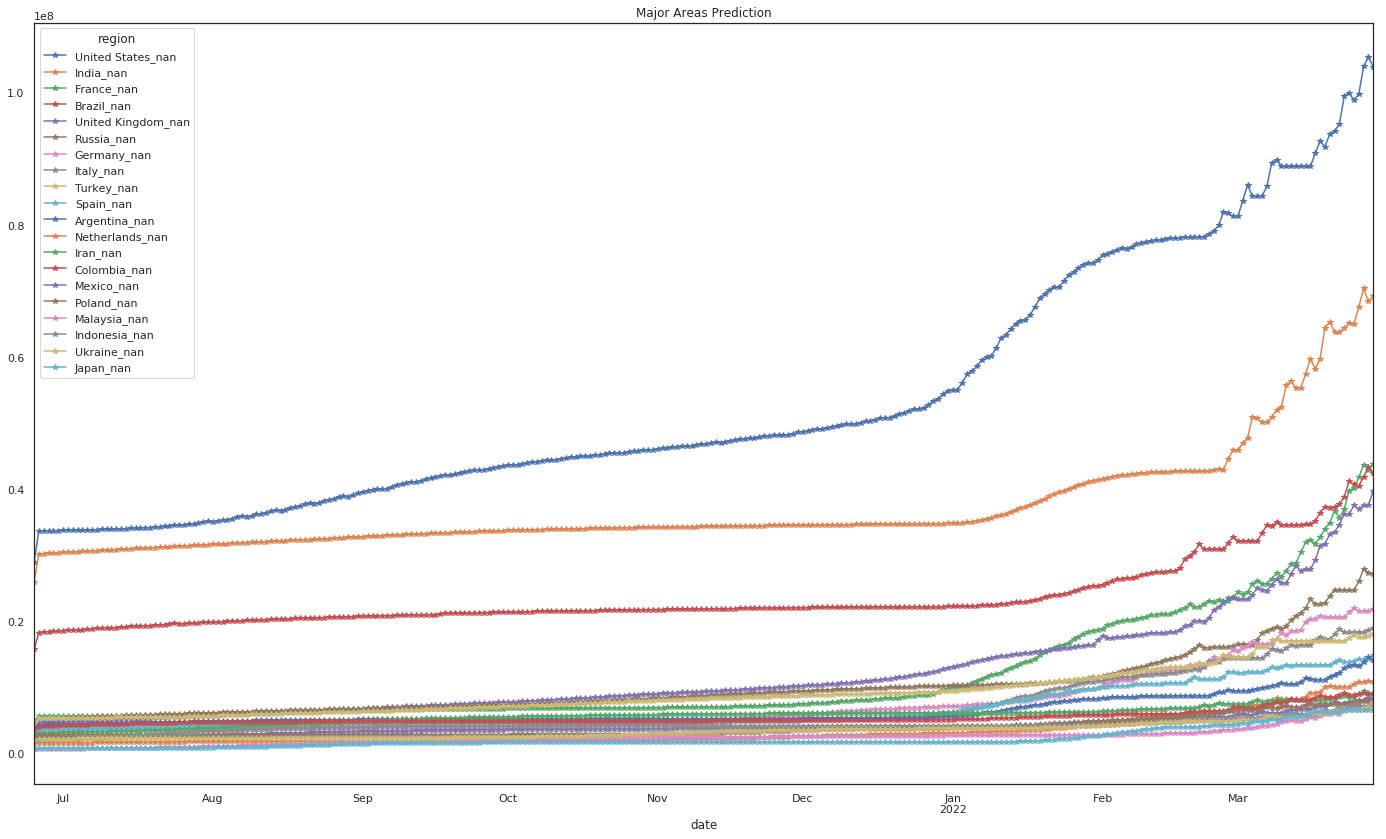

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

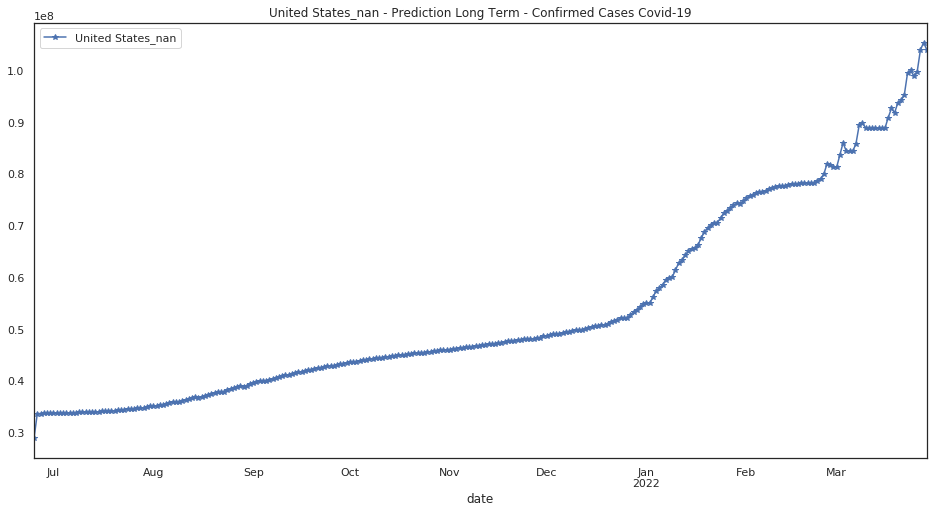

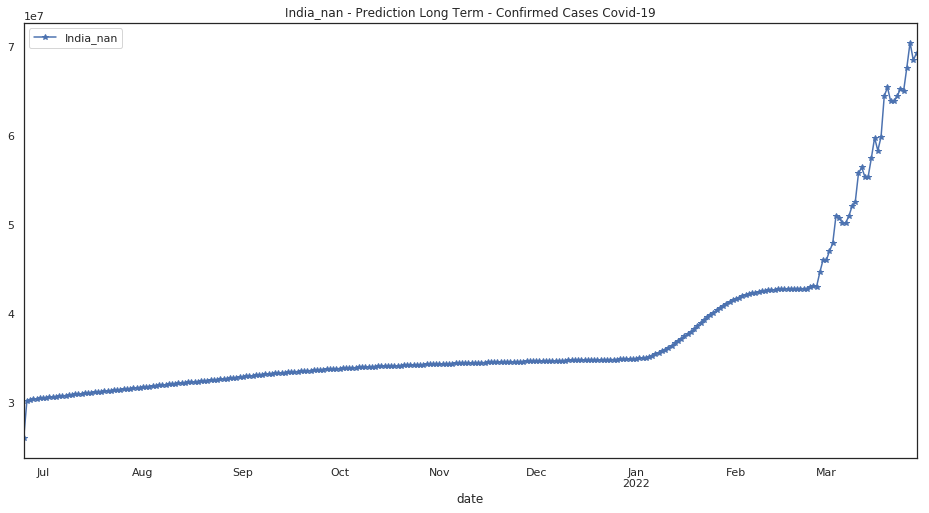

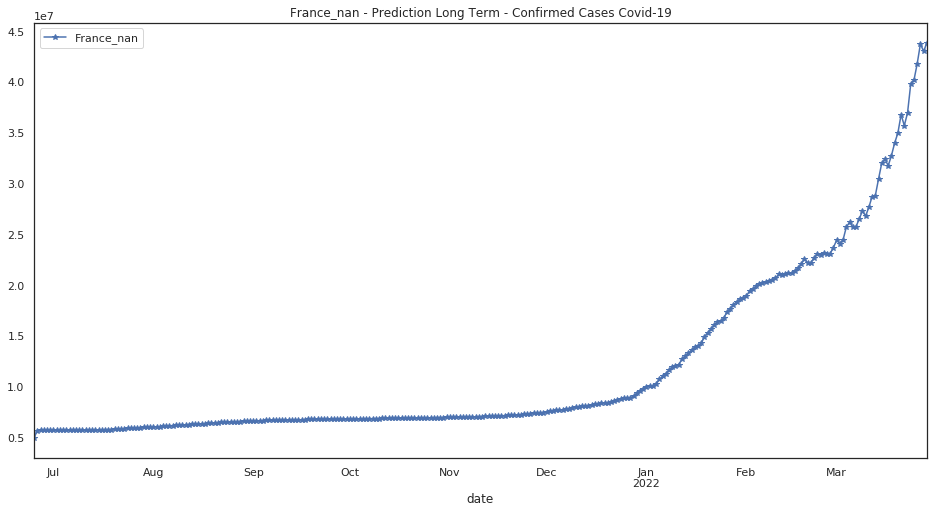

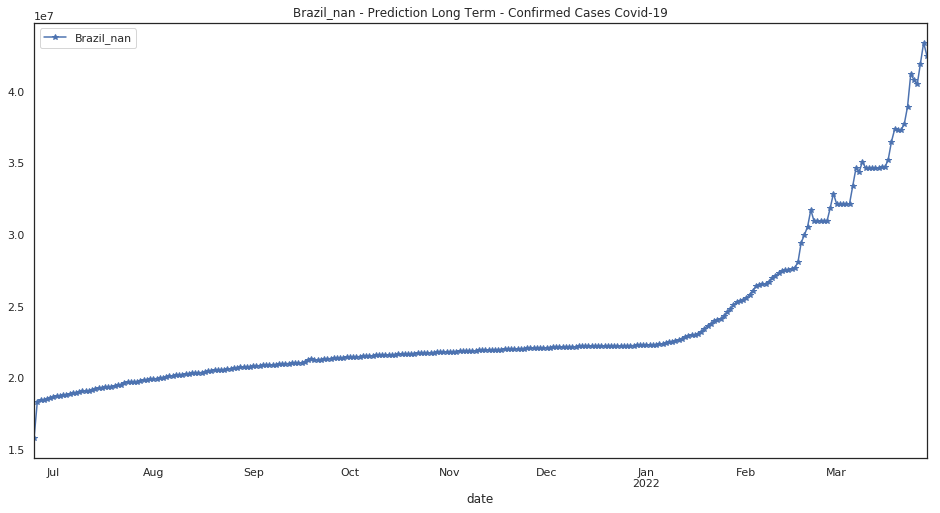

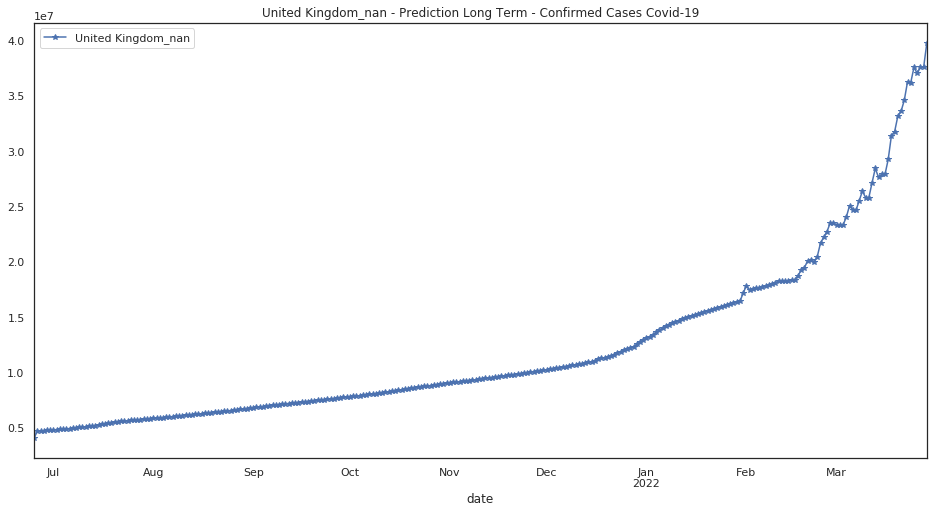

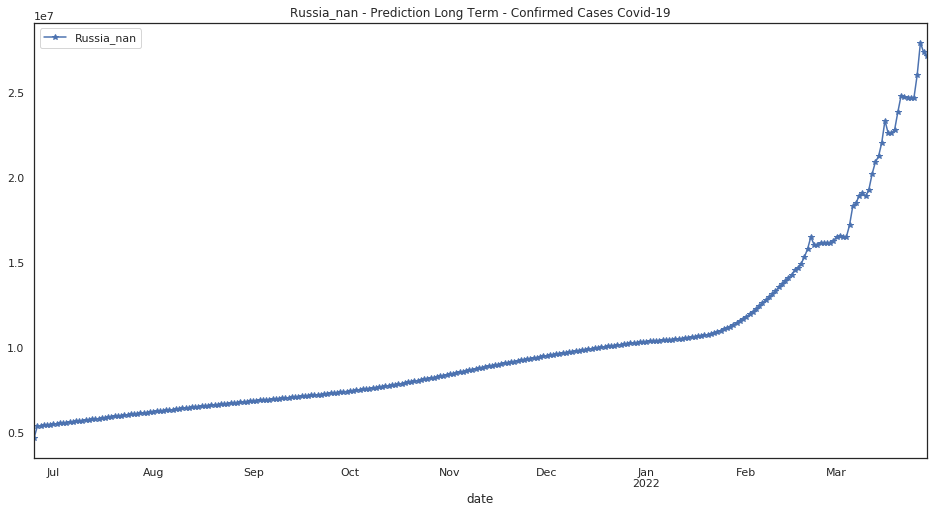

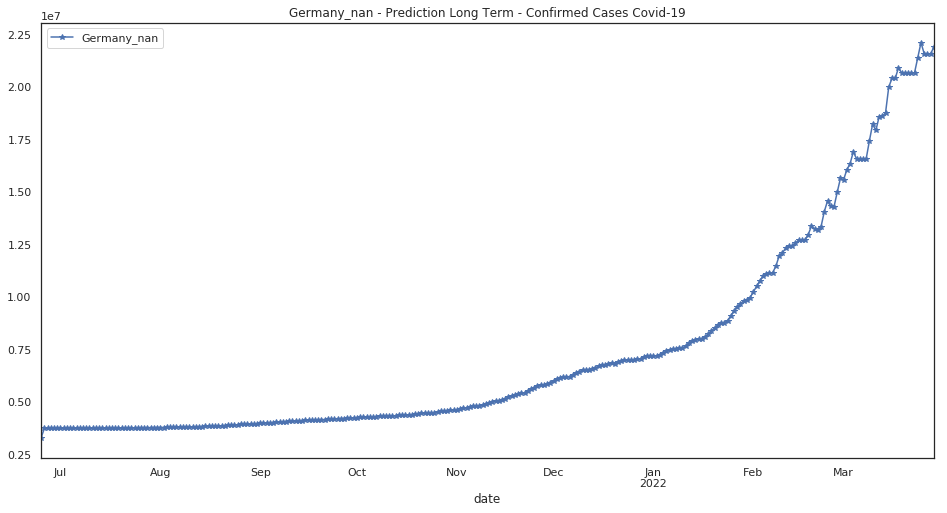

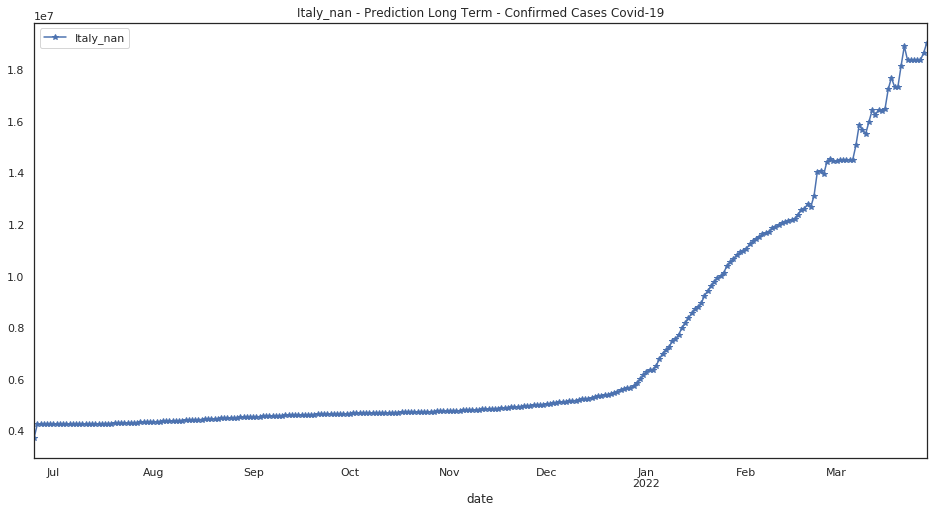

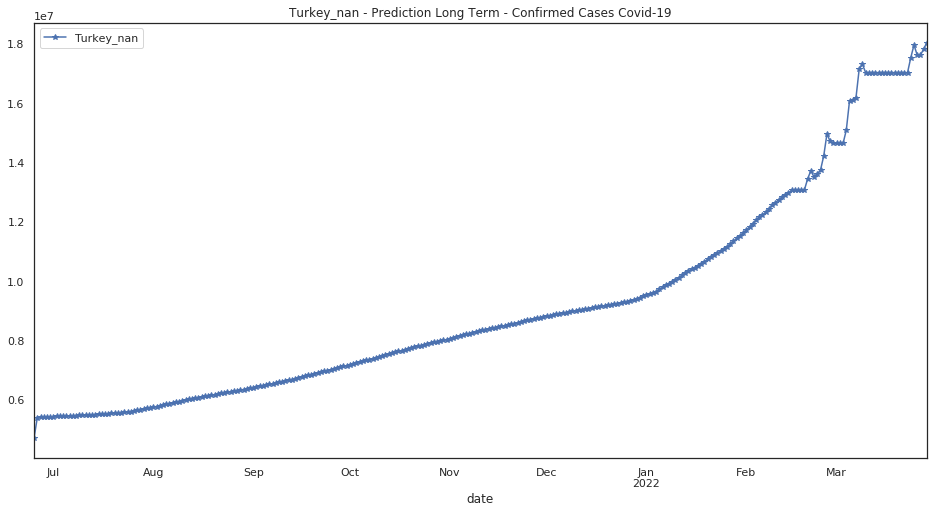

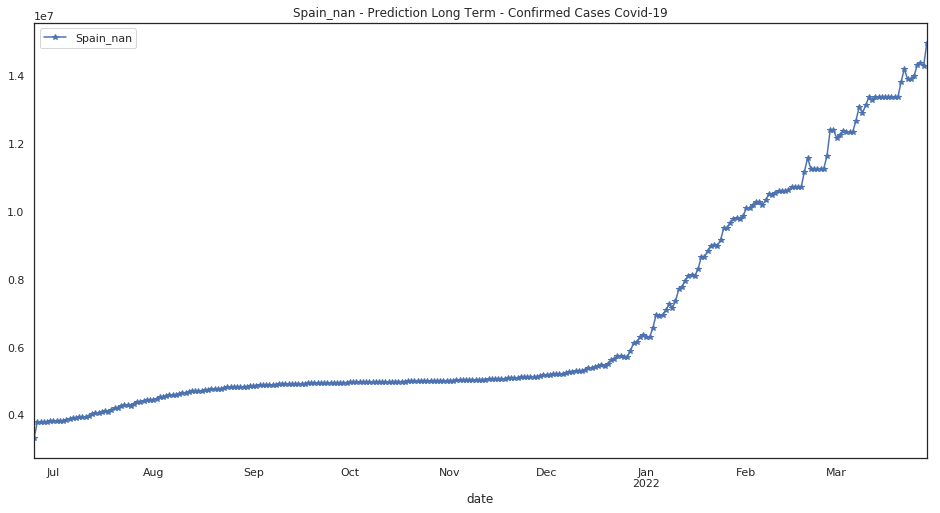

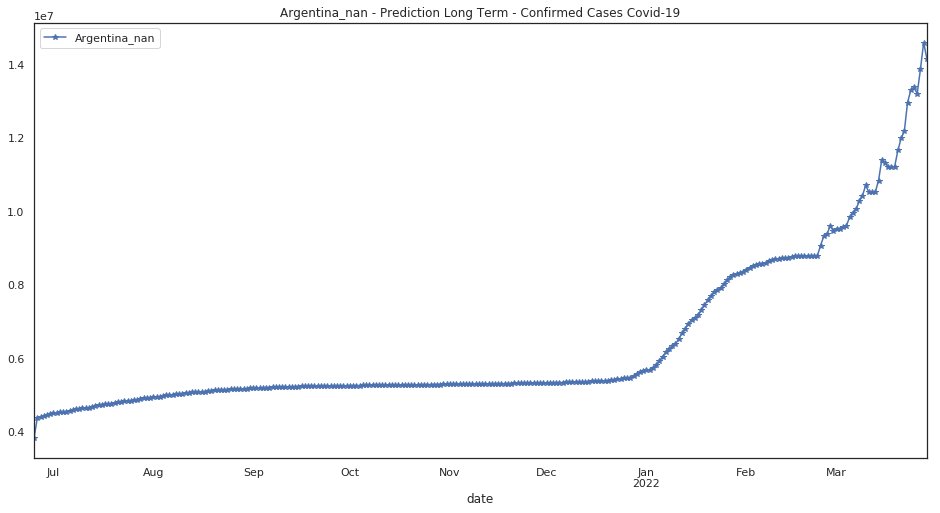

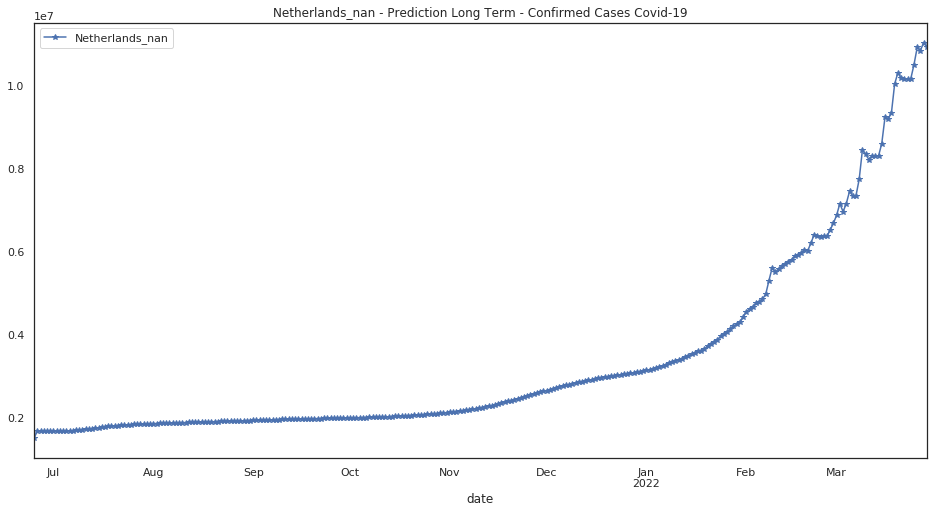

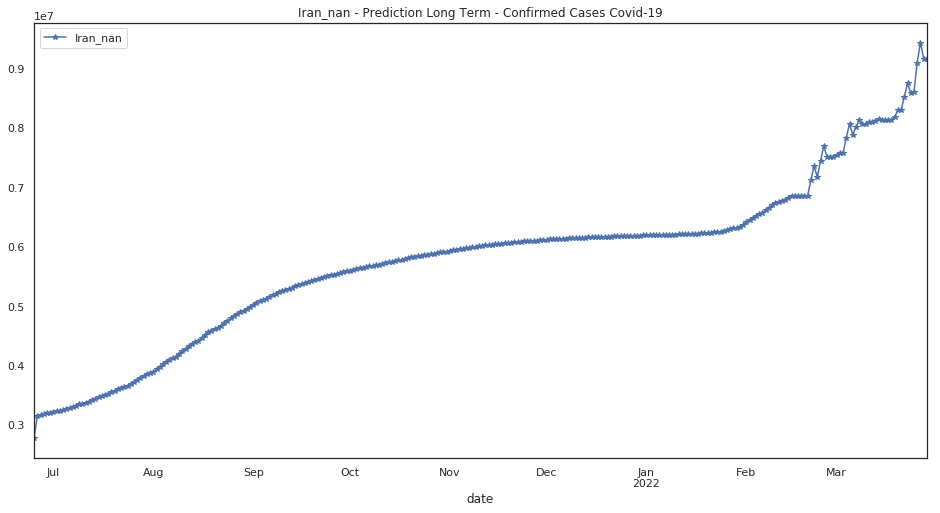

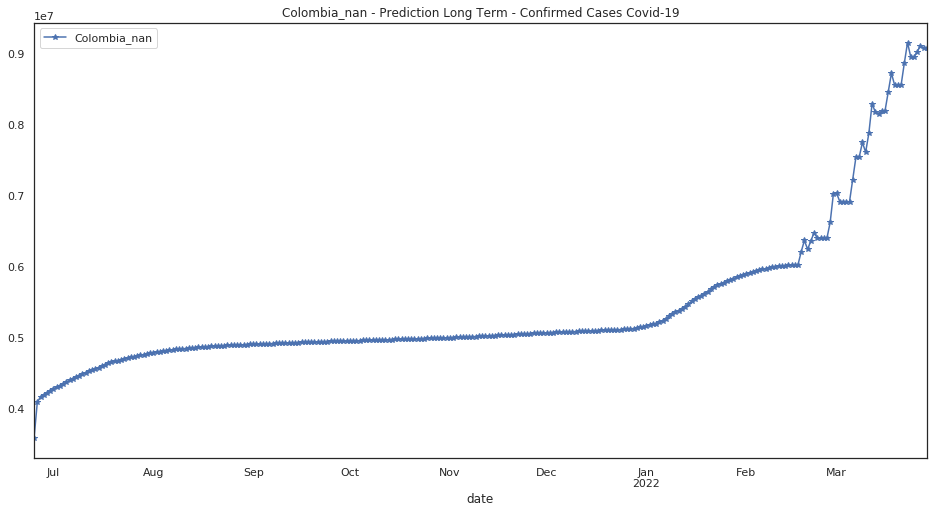

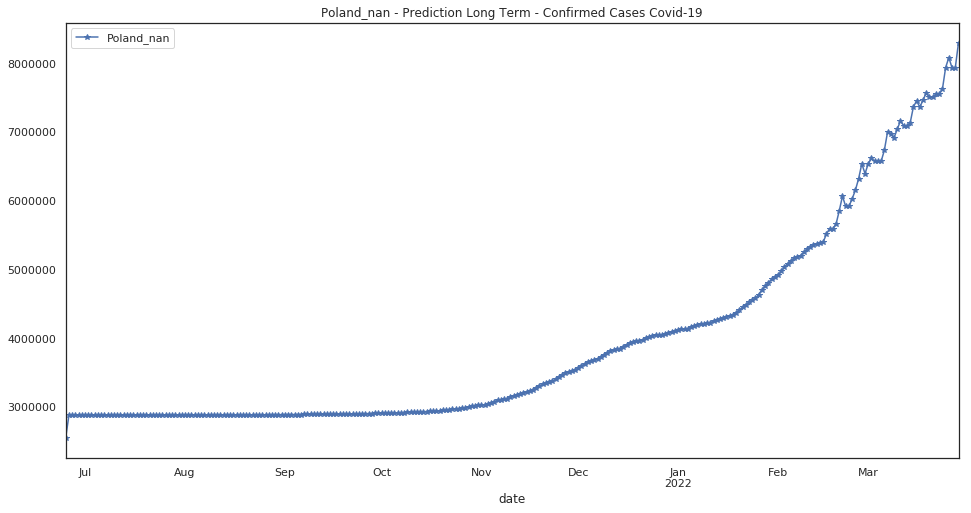

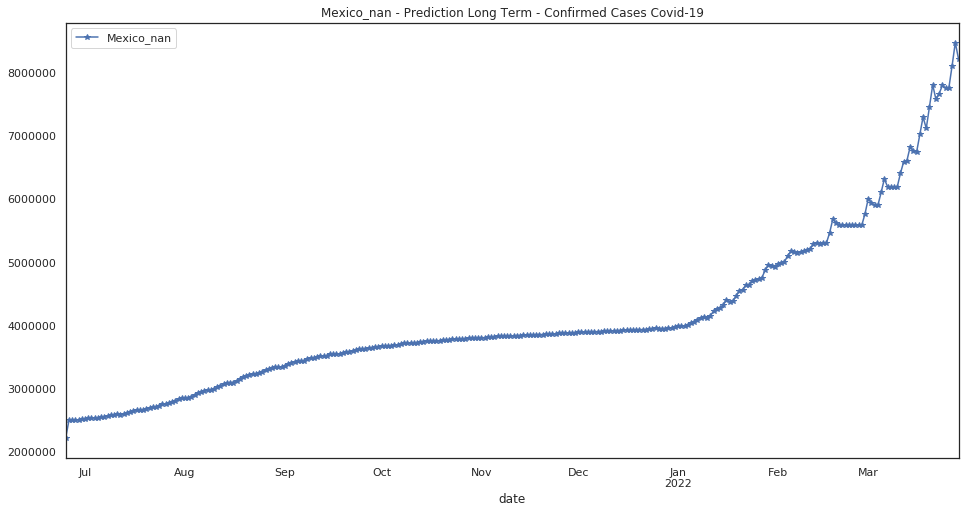

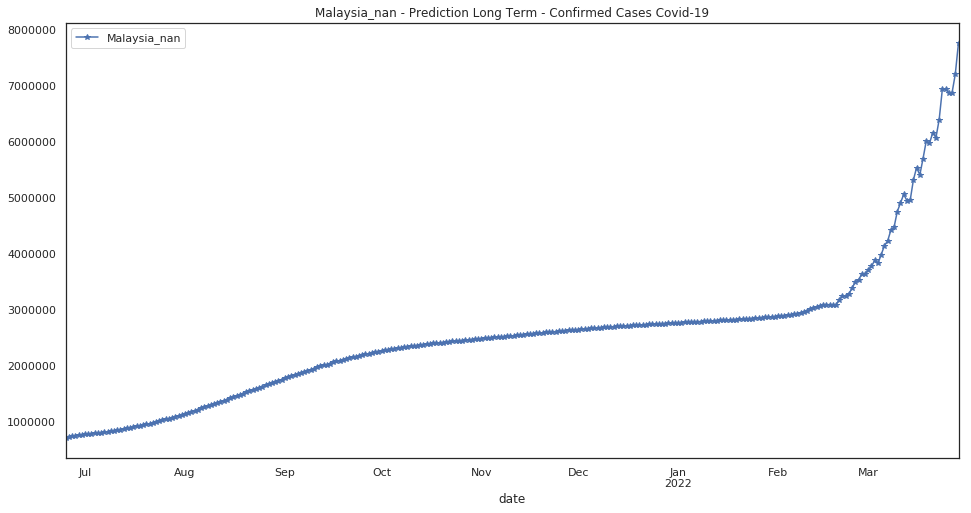

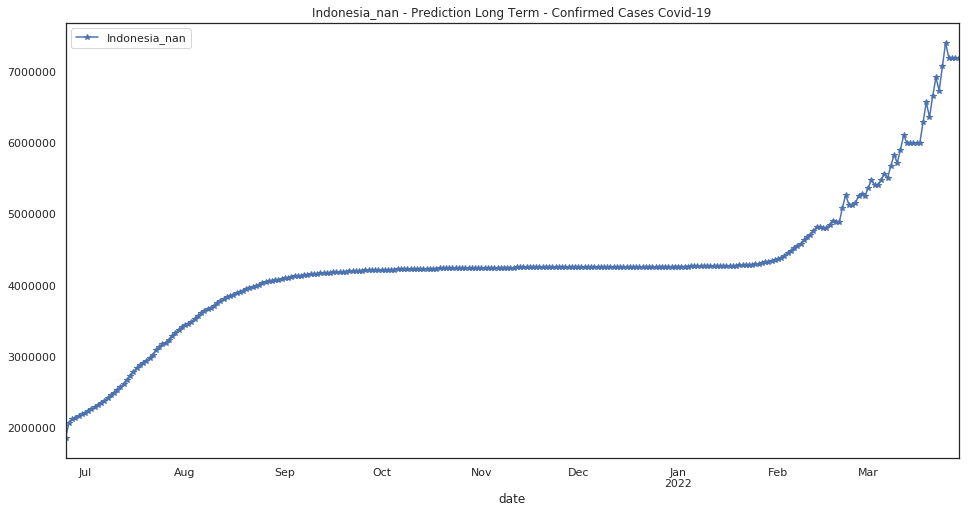

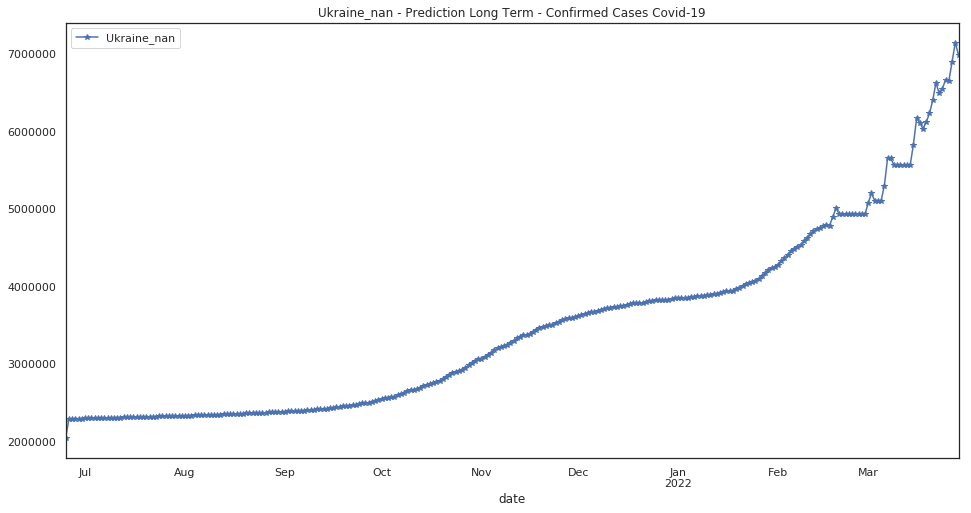

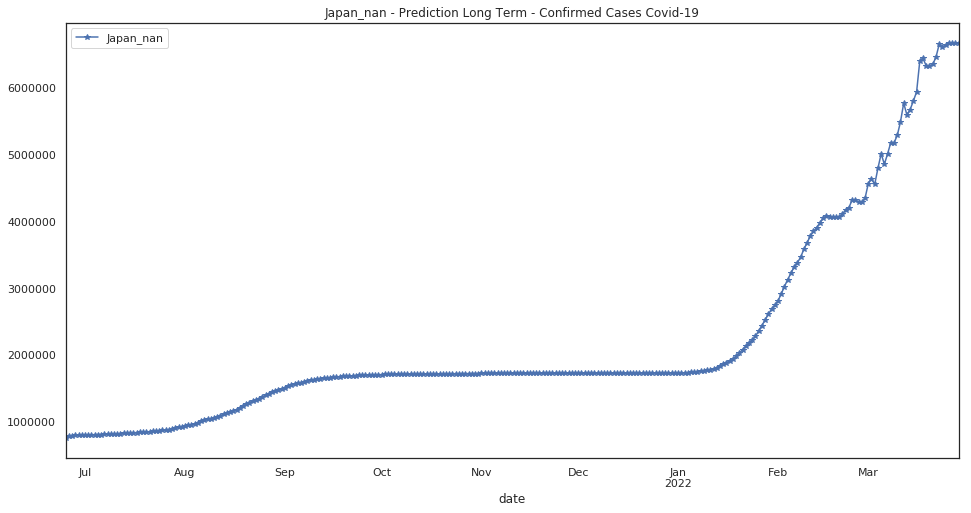

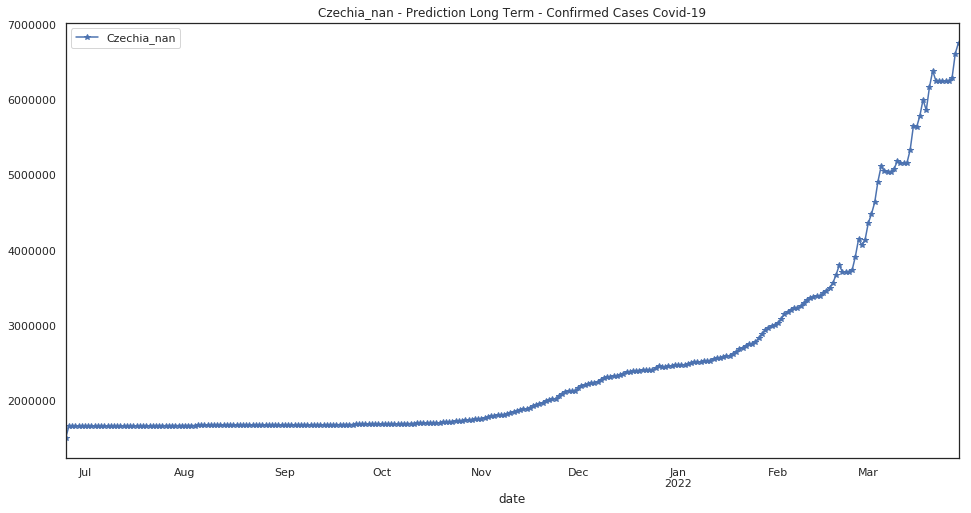

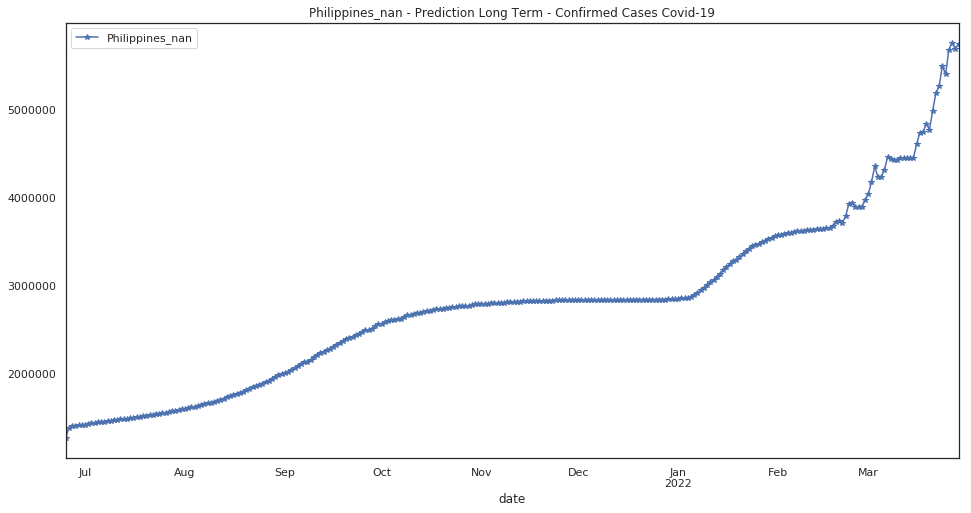

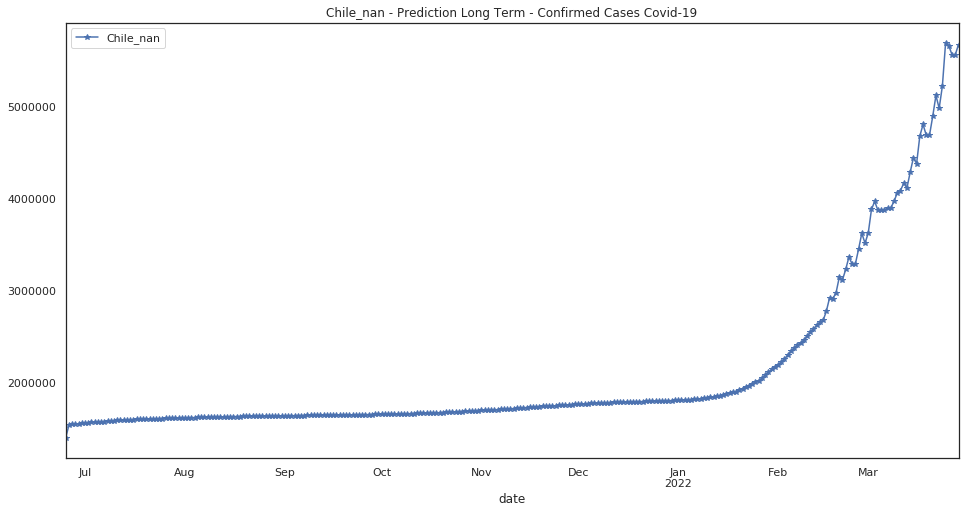

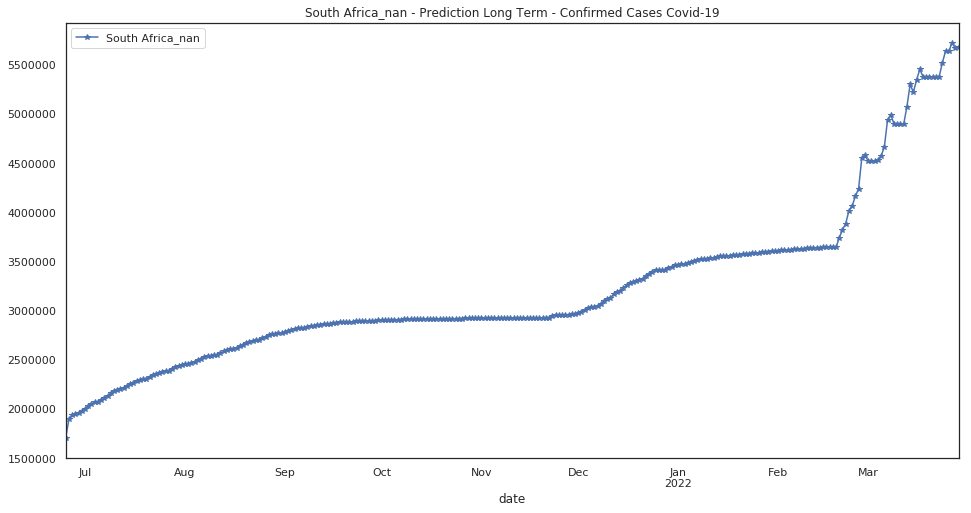

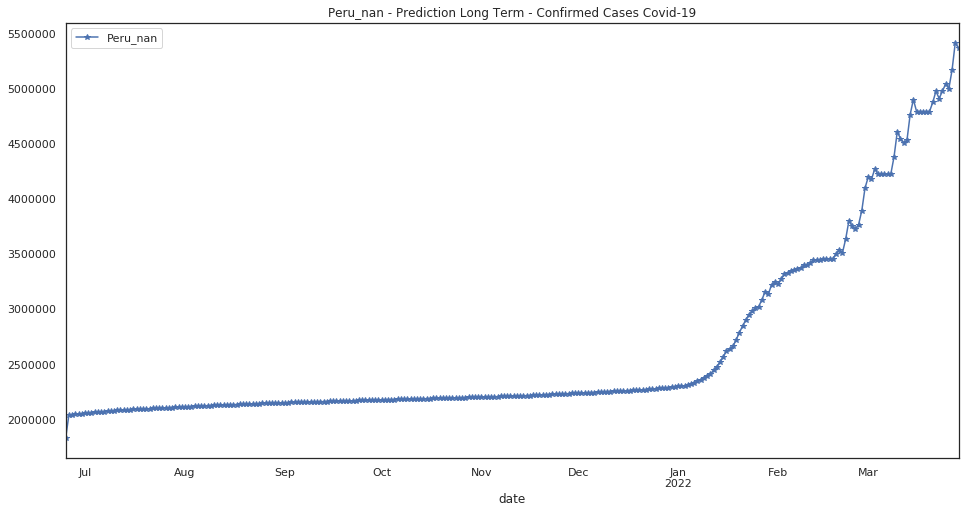

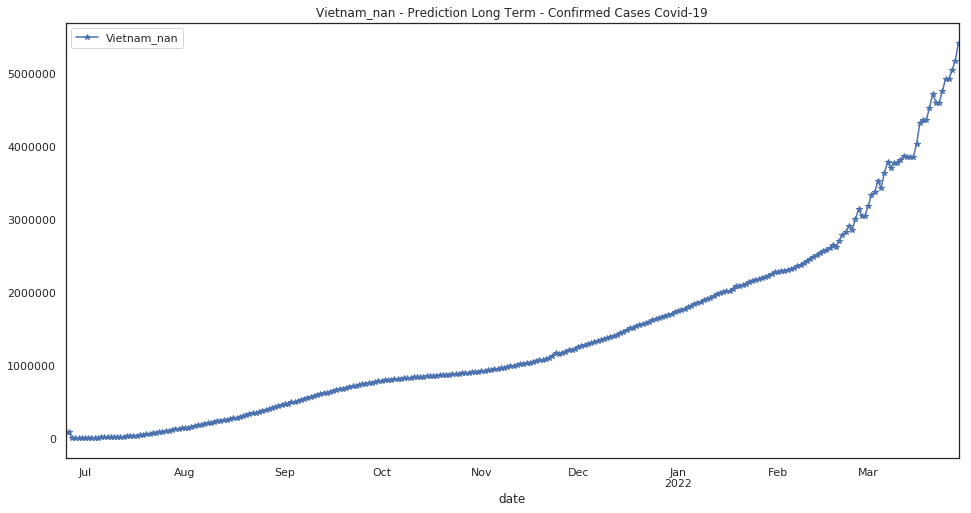

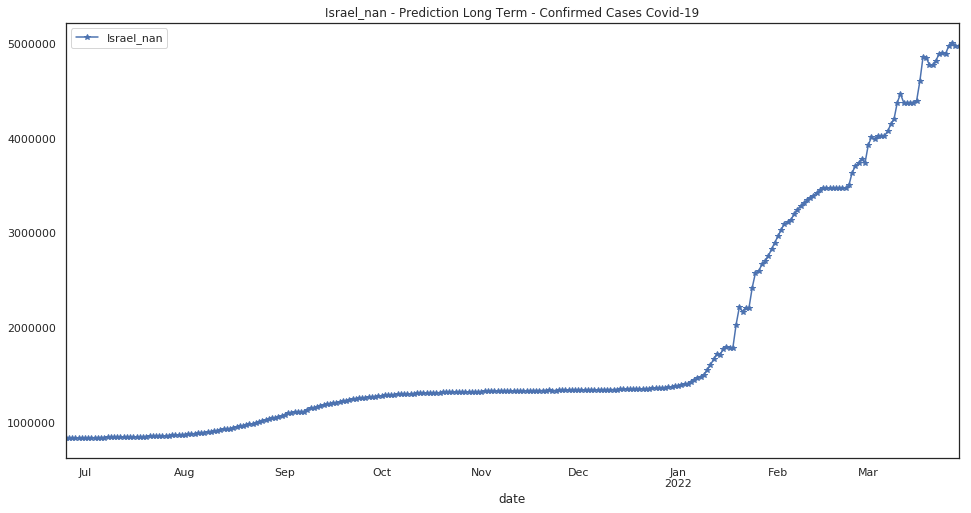

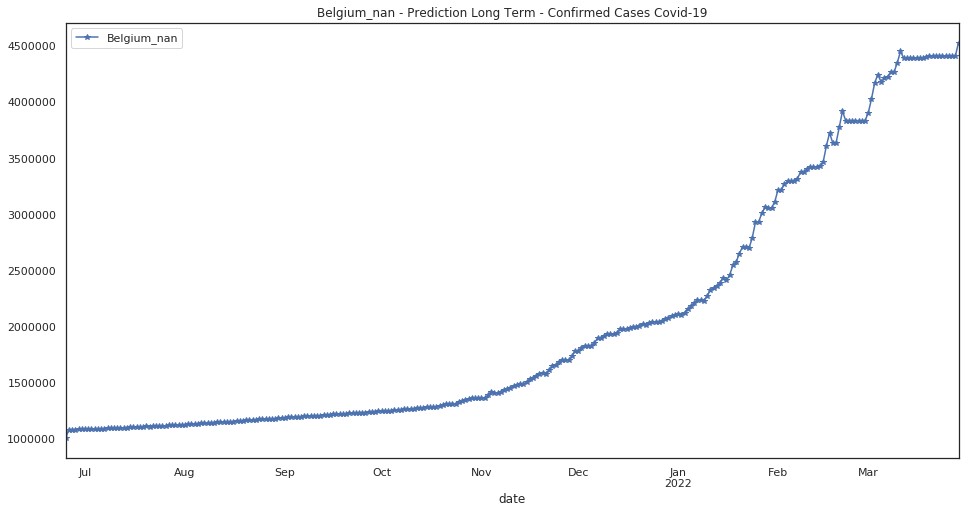

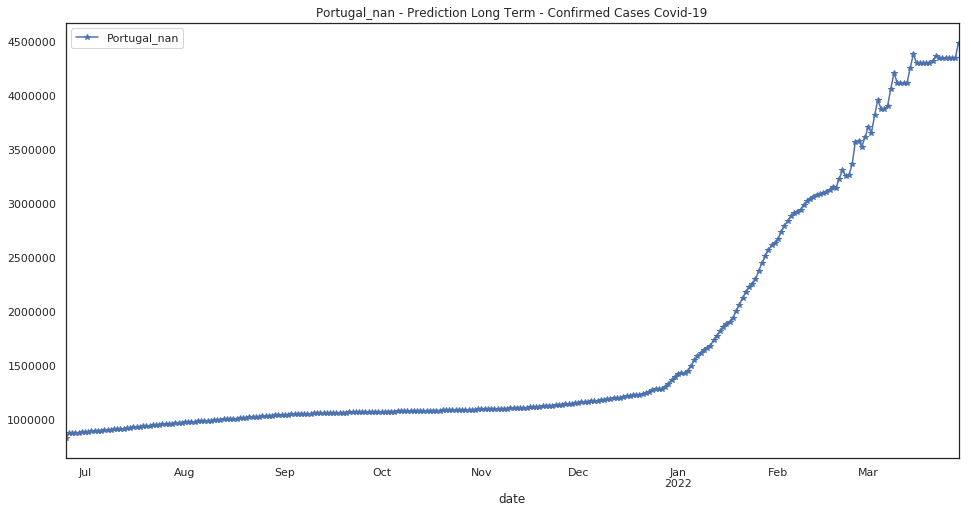

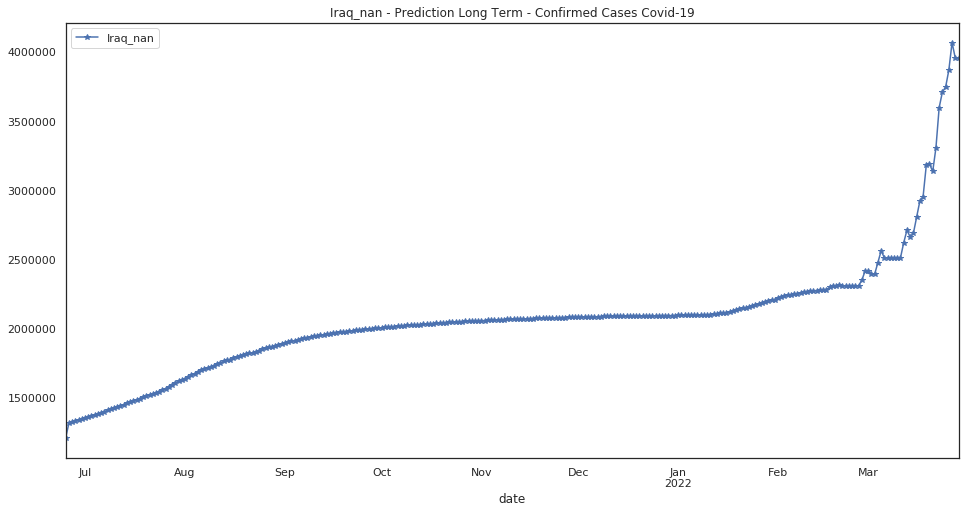

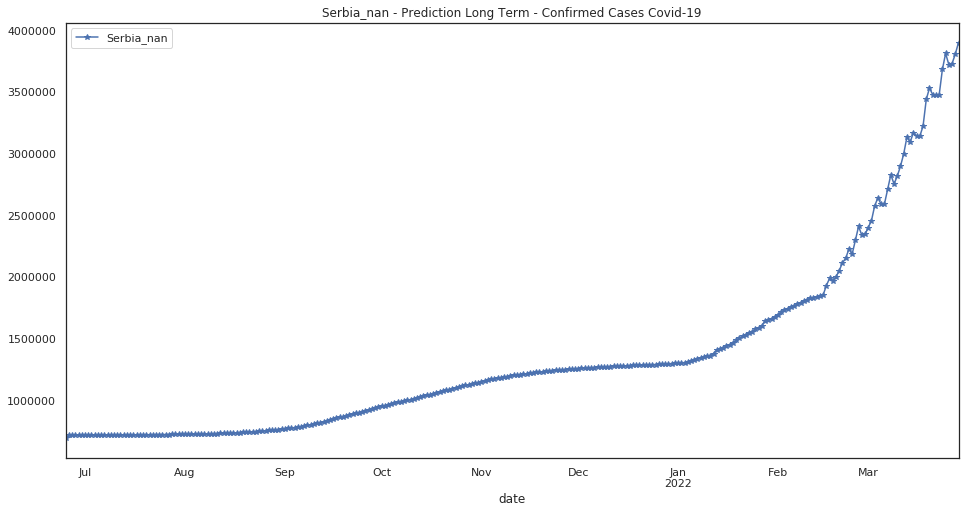

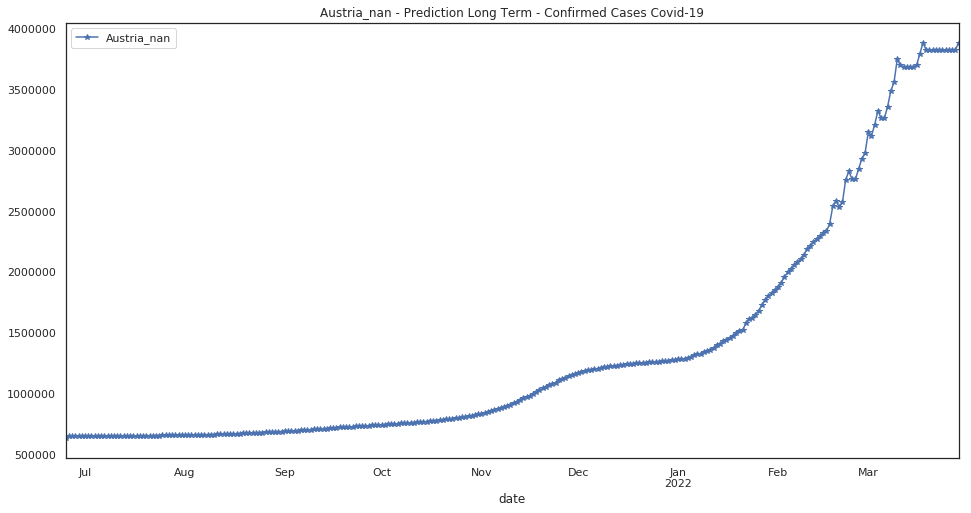

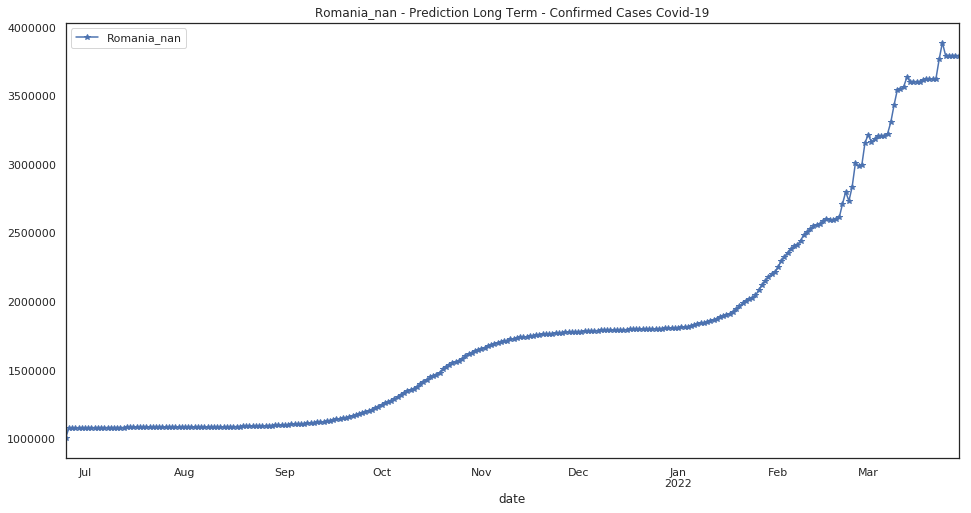

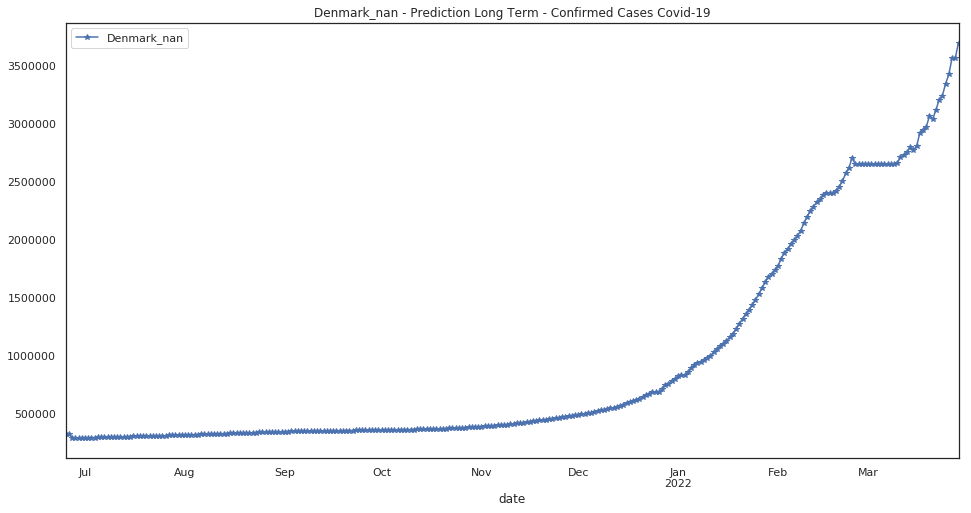

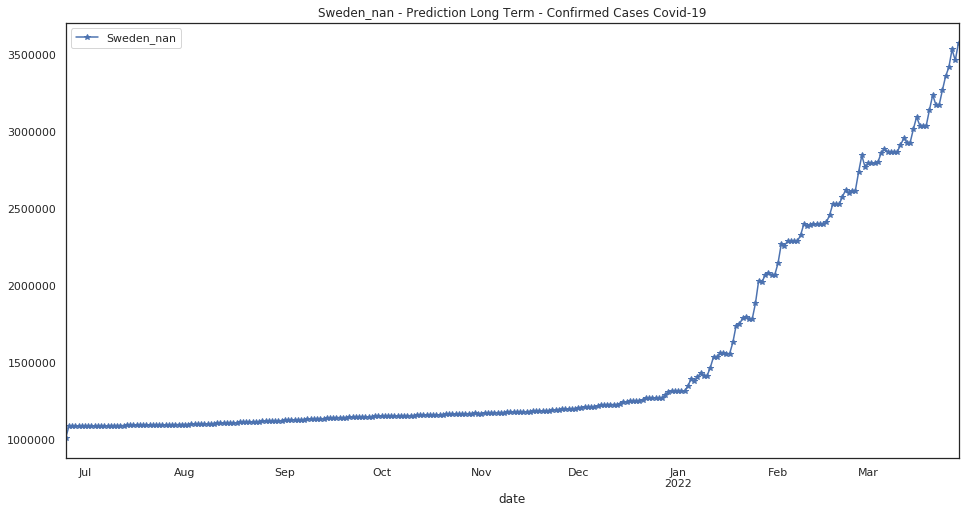

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

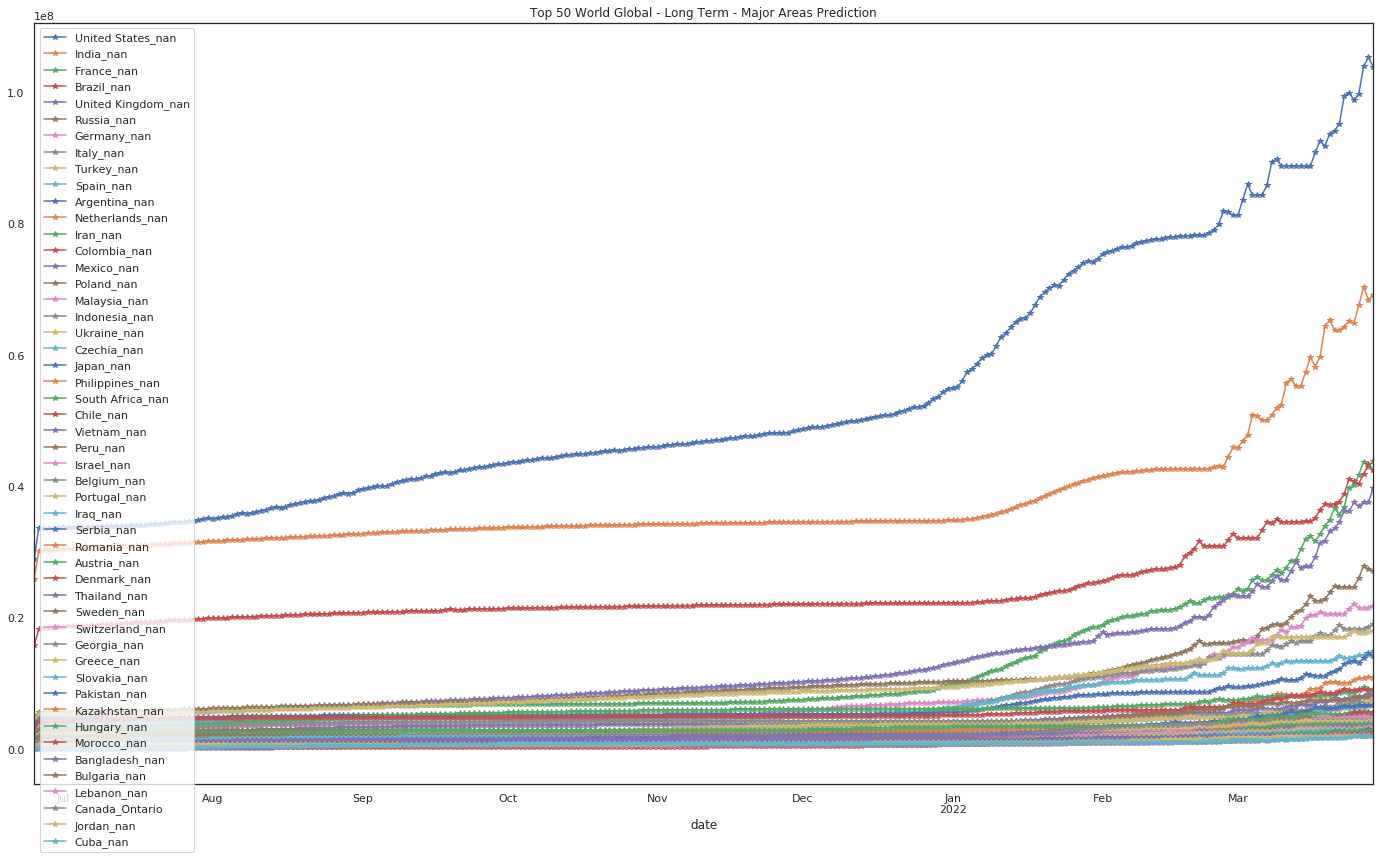

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

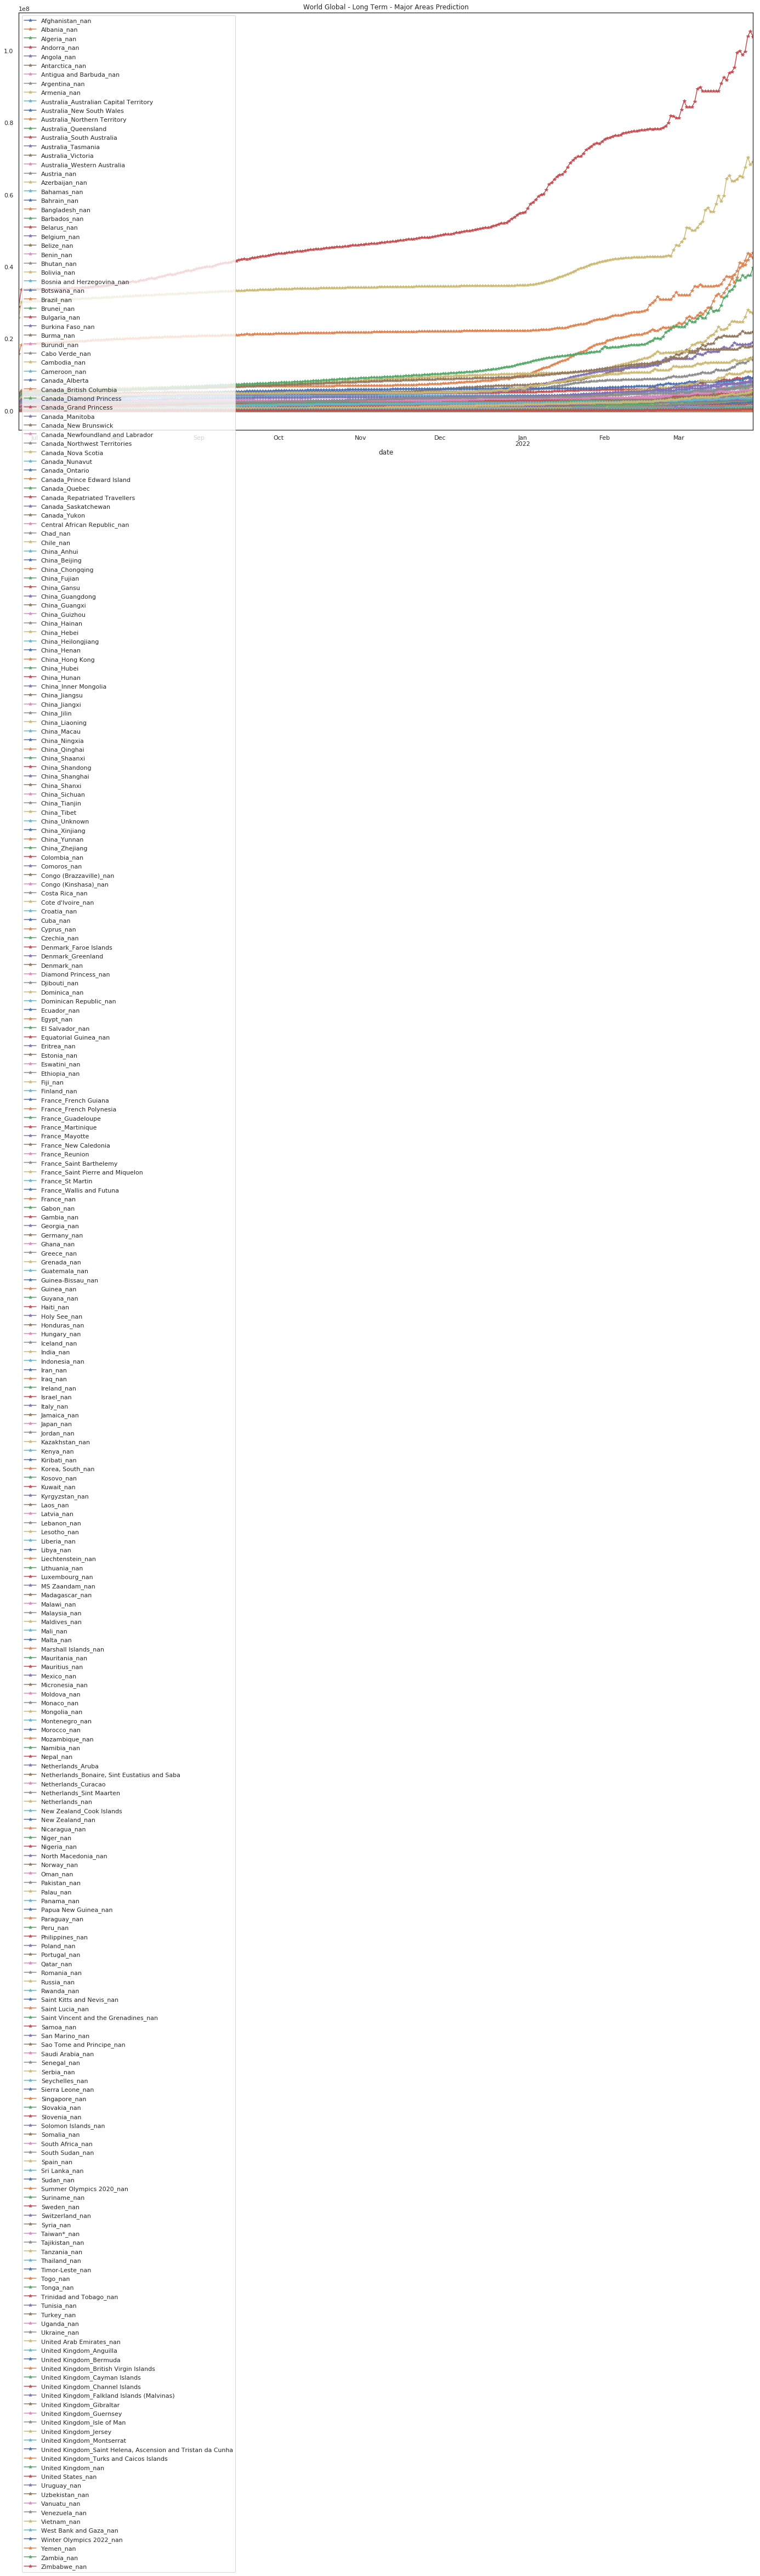

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-08-09         152454.0     135256.0     183799.0      14836.0   
2021-08-10         152721.0     135443.0     184793.0      14836.0   
2021-08-11         152998.0     135720.0     185671.0      14873.0   
2021-08-12         153283.0     135990.0     186529.0      14891.0   
2021-08-13         153507.0     136350.0     187414.0      14908.0   
2021-08-14         153688.0     136751.0     188203.0      14924.0   
2021-08-15         153800.0     137137.0     188826.0      14924.0   
2021-08-16         153900.0     137354.0     189508.0      14924.0   
2021-08-17         154014.0     137744.0     190244.0      14954.0   
2021-08-18         154137.0     138219.0     190975.0      14960.0   
2021-08-19         154208.0     138726.0     191689.0      14976.0   
2021-08-20         154249.0     139254.0     192287.0      14981.0   
2021-08-21         154304.0     139887.0     192800.0      14988.0   
2021-08-22         154330.0     140435.0     193222.0      14988.0   
2021-08-23         154393.0     140833.0     193697.0      14988.0   
2021-08-24         154480.0     141549.0     194263.0      15002.0   
2021-08-25         154547.0     142399.0     194825.0      15003.0   
2021-08-26         154644.0     143269.0     195349.0      15014.0   
2021-08-27         154779.0     144178.0     195862.0      15016.0   
2021-08-28         154839.0     145067.0     196357.0      15025.0   
2021-08-29         154856.0     145838.0     196841.0      15025.0   
2021-08-30         154953.0     146333.0     197260.0      15025.0   
2021-08-31         155039.0     147261.0     197738.0      15032.0   
2021-09-01         155079.0     148296.0     198218.0      15033.0   
2021-09-02         155122.0     149155.0     198606.0      15046.0   
2021-09-03         155190.0     150039.0     198990.0      15052.0   
2021-09-04         155224.0     151010.0     199353.0      15055.0   
2021-09-05         155245.0     151922.0     199695.0      15055.0   
2021-09-06         155345.0     152461.0     200016.0      15055.0   
2021-09-07         155452.0     153107.0     200340.0      15069.0   
...                     ...          ...          ...          ...   
2022-02-28         210901.0     295561.0     271898.0      40516.0   
2022-03-01         211480.0     296157.0     272205.0      41903.0   
2022-03-02         209783.0     293459.0     272438.0      41903.0   
2022-03-03         209639.0     309346.0     272438.0      41903.0   
2022-03-04         210023.0     317373.0     272438.0      41903.0   
2022-03-05         213663.0     318415.0     272438.0      41903.0   
2022-03-06         223762.0     322829.0     272438.0      41903.0   
2022-03-07         226806.0     321575.0     272438.0      41903.0   
2022-03-08         225874.0     321575.0     272438.0      41903.0   
2022-03-09         226468.0     321575.0     272438.0      41903.0   
2022-03-10         225764.0     322907.0     272438.0      41935.0   
2022-03-11         225764.0     325734.0     272438.0      41935.0   
2022-03-12         225733.0     324813.0     272438.0      41935.0   
2022-03-13         226004.0     325014.0     272438.0      43838.0   
2022-03-14         229358.0     324965.0     272438.0      43838.0   
2022-03-15         230615.0     324965.0     279365.0      43838.0   
2022-03-16         229768.0     324965.0     283039.0      43838.0   
2022-03-17         236813.0     324965.0     280098.0      43838.0   
2022-03-18         240056.0     325186.0     281732.0      43838.0   
2022-03-19         237528.0     325186.0     282481.0      44289.0   
2022-03-20         237528.0     338831.0     281771.0      44289.0   
2022-03-21         237378.0     346754.0     284438.0      44289.0   
2022-03-22         237583.0     340715.0     285853.0      44356.0   
2022-03-23         239956.0     340715.0     285227.0      46559.0   
2022-03-24

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
260                                        Tunisia_nan  33.886917    9.537499   
261                                         Turkey_nan  38.963700   35.243300   
262                                  United States_nan  40.000000 -100.000000   
263                                         Uganda_nan   1.373333   32.290275   
264                                        Ukraine_nan  48.379400   31.165600   
265                           United Arab Emirates_nan  23.424076   53.847818   
266                            United Kingdom_Anguilla  18.220600  -63.068600   
267                             United Kingdom_Bermuda  32.307800  -64.750500   
268              United Kingdom_British Virgin Islands  18.420700  -64.640000   
269                      United Kingdom_Cayman Islands  19.313300  -81.254600   
270                     United Kingdom_Channel Islands  49.372300   -2.364400   
271         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
272                           United Kingdom_Gibraltar  36.140800   -5.353600   
273                            United Kingdom_Guernsey  49.448196   -2.589490   
274                         United Kingdom_Isle of Man  54.236100   -4.548100   
275                              United Kingdom_Jersey  49.213800   -2.135800   
276                          United Kingdom_Montserrat  16.742498  -62.187366   
277  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index              region        Lat        Long  2021-06-25 00:00:00  \
0       7       Argentina_nan -38.416100  -63.616700            3832780.0   
1      17         Austria_nan  47.516200   14.550100             636687.0   
2      21      Bangladesh_nan  23.685000   90.356300             833012.0   
3      24         Belgium_nan  50.833300    4.469936            1007785.0   
4      31          Brazil_nan -14.235000  -51.925300           15810204.0   
5      33        Bulgaria_nan  42.733900   25.485800             440584.0   
6      52      Canada_Ontario  51.253800  -85.323200             545345.0   
7      60           Chile_nan -35.675100  -71.543000            1398221.0   
8      95        Colombia_nan   4.570900  -74.297300            3590929.0   
9     102            Cuba_nan  21.521757  -77.781167             231004.0   
10    104         Czechia_nan  49.817500   15.473000            1509102.0   
11    107         Denmark_nan  56.263900    9.501800             329962.0   
12    133          France_nan  46.227600    2.213700            4969974.0   
13    136         Georgia_nan  42.315400   43.356900             389694.0   
14    137         Georgia_nan  42.315400   43.356900             389694.0   
15    138         Germany_nan  51.165691   10.451526            3282798.0   
16    140          Greece_nan  39.074200   21.824300             439561.0   
17    150         Hungary_nan  47.162500   19.503300             772177.0   
18    152           India_nan  20.593684   78.962880           25979370.0   
19    153       Indonesia_nan  -0.789300  113.921300            1857650.0   
20    154            Iran_nan  32.427908   53.688046            2782763.0   
21    155            Iraq_nan  33.223191   43.679291            1208533.0   
22    157          Israel_nan  31.046051   34.851612             840638.0   
23    158          Israel_nan  31.046051   34.851612             840638.0   
24    159           Italy_nan  41.871940   12.567380            3731406.0   
25    161           Japan_nan  36.204824  138.252924             758927.0   
26    162          Jordan_nan  31.240000   36.510000             721666.0   
27    163      Kazakhstan_nan  48.019600   66.923700             484983.0   
28    172         Lebanon_nan  33.854700   35.862300             545855.0   
29    173         Lebanon_nan  33.854700   35.862300             545855.0   
30    183        Malaysia_nan   4.210484  101.975766             699023.0   
31    190          Mexico_nan  23.634500 -102.552800            2222767.0   
32    196         Morocco_nan  31.791700   -7.092600             532611.0   
33    204     Netherlands_nan  52.132600    5.291300            1522433.0   
34    213        Pakistan_nan  30.375300   69.345100             897403.0   
35    218            Peru_nan  -9.190000  -75.015200            1832246.0   
36    219     Philippines_nan  12.879721  121.774017            1267430.0   
37    220          Poland_nan  51.919400   19.145100            2549804.0   
38    221        Portugal_nan  39.399900   -8.224500             826730.0   
39    223         Romania_nan  45.943200   24.966800            1006109.0   
40    224          Russia_nan  61.524010  105.318756            4666364.0   
41    234          Serbia_nan  44.016500   21.005900             693456.0   
42    238        Slovakia_nan  48.669000   19.699000             743690.0   
43    242    South Africa_nan -30.559500   22.937500            1705797.0   
44    244           Spain_nan  40.463667   -3.749220            3324672.0   
45    249          Sweden_nan  60.128161   18.643501            1013294.0   
46    250     Switzerland_nan  46.818200    8.227500             681730.0   
47    255        Thailand_nan  15.870032  100.992541             281665.0   
48    261          Turkey_nan  38.963700   35.243300            4711735.0   
49    262   United States_nan  40.000000 -100.000000           29021732.0   
50    264         Ukraine_nan  48.379400   31.165600            2049014.0   


In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()